In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

#モデル
import lightgbm as lgb

#パラメータ探索
import optuna

#クロスバリデーション
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold

# 評価指標
import sys
sys.path.append('./evaluation')
from rmse import rmse
from recall5 import recall5
from profit import profit

# #エヴァリュエーション
# from sklearn.metrics import precision_score, recall_score, mean_squared_error

#可視化
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

#保存
import pickle

In [2]:
#データを読み込む
n_uma_race_df = pd.read_pickle('../datasets/traindata/n_uma_race.pkl')
n_race_df = pd.read_pickle('../datasets/traindata/n_race.pkl')
n_payout_df = pd.read_pickle('../datasets/traindata/n_payout.pkl')

In [3]:
# 新しいグループを作成
n_uma_race_df['group'] = n_uma_race_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_uma_race_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_uma_race_df['keibajo_code'].astype(int).astype(str) +"-"+  n_uma_race_df['race_bango'].astype(int).astype(str)
n_race_df['group'] = n_race_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_race_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_race_df['keibajo_code'].astype(int).astype(str) +"-"+  n_race_df['race_bango'].astype(int).astype(str)
n_payout_df['group'] = n_payout_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_payout_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_payout_df['keibajo_code'].astype(int).astype(str) +"-"+  n_payout_df['race_bango'].astype(int).astype(str)

n_race_df_drop = n_race_df.drop(['kaisai_nen', 'kaisai_tsukihi', 'keibajo_code', 'kaisai_kai', 'kaisai_nichime', 'race_bango'],axis=1)
n_payout_df_drop = n_payout_df.drop(['kaisai_nen', 'kaisai_tsukihi', 'keibajo_code', 'kaisai_kai', 'kaisai_nichime', 'race_bango', 'toroku_tosu', 'shusso_tosu'],axis=1)

merged_df = pd.merge(n_uma_race_df, n_race_df_drop, on='group', how='left')
merged_df = pd.merge(merged_df, n_payout_df_drop, on='group', how='left')
merged_df['group'].nunique()

205318

In [4]:
merged_df['hutan_wariai'] = merged_df['futan_juryo'] / merged_df['bataiju']
def combine_sign_and_diff(row):
    if row['zogen_fugo'] == 2:
        return row['zogen_sa']
    elif row['zogen_fugo'] == 0:
        return -row['zogen_sa']
    else:
        return 0

merged_df['zogen_ryou'] = merged_df.apply(combine_sign_and_diff, axis=1)
merged_df = merged_df[merged_df['ijo_kubun_code'] == 0]

In [5]:
columns_to_convert = [
                    'kyori',
                    'grade_code',
                    'seibetsu_code',
                    'moshoku_code',
                    'barei',
                    'chokyoshi_code',
                    'banushi_code',
                    'kishu_code',
                    'kishu_minarai_code',
                    'kyoso_shubetsu_code',
                    'juryo_shubetsu_code',
                    'shusso_tosu',
                    'tenko_code',
                    'babajotai_code_dirt',
                    'hutan_wariai',
                    'zogen_ryou',
                    'track_code',
                    'keibajo_code',
                    'hinshu_code',
                    'umakigo_code'
                    ]

for column in columns_to_convert:
    merged_df[column].fillna(0, inplace=True)
    try:
        if merged_df[column].astype(float).apply(lambda x: x.is_integer()).all():
            merged_df[column] = merged_df[column].astype(int)
        else:
            merged_df[column] = merged_df[column].astype(float)
    except ValueError:
        merged_df[column] = merged_df[column].astype(float)

    print(f"{column} のデータ型: {merged_df[column].dtype}")

kyori のデータ型: int32
grade_code のデータ型: int32
seibetsu_code のデータ型: int32
moshoku_code のデータ型: int32
barei のデータ型: int32
chokyoshi_code のデータ型: int32
banushi_code のデータ型: int32
kishu_code のデータ型: int32
kishu_minarai_code のデータ型: int32
kyoso_shubetsu_code のデータ型: int32
juryo_shubetsu_code のデータ型: int32
shusso_tosu のデータ型: int32
tenko_code のデータ型: int32
babajotai_code_dirt のデータ型: int32
hutan_wariai のデータ型: float64
zogen_ryou のデータ型: int32
track_code のデータ型: int32
keibajo_code のデータ型: int32
hinshu_code のデータ型: int32
umakigo_code のデータ型: int32


In [6]:
def modify_rankings(df, column_name='kakutei_chakujun'):
    """
    この関数はDataFrameの特定の列のランキングを修正します。
    - df: DataFrameオブジェクト
    - column_name: 修正する列の名前（デフォルトは 'kakutei_chakujun'）
    """
    conditions = [
        (df[column_name] == 1),
        (df[column_name] == 2),
        (df[column_name] == 3),
        (df[column_name] == 4),
        (df[column_name] == 5)
    ]
    
    values = [5, 4, 3, 2, 1]
    
    df['target'] = np.select(conditions, values, default=0)
    
    return df
merged_df = modify_rankings(merged_df)

In [7]:
# 2010年から2019年のデータを学習データとして取得
train_data = merged_df[merged_df['kaisai_nen'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
test_data = merged_df[merged_df['kaisai_nen'].isin([2020, 2021, 2022])]

In [8]:
features = [
            'seibetsu_code',
            'moshoku_code',
            'barei',
            'chokyoshi_code',
            'banushi_code',
            'kishu_code',
            'kishu_minarai_code',
            'kyoso_shubetsu_code',
            'juryo_shubetsu_code',
            'hutan_wariai',
            'zogen_ryou',
            ]

target = 'target'

In [9]:
categorical_features = ['seibetsu_code',
                        'moshoku_code',
                        'chokyoshi_code',
                        'banushi_code',
                        'kishu_code',
                        'kishu_minarai_code',
                        'hinshu_code',
                        'umakigo_code',
                       ]

In [10]:
# モデルの保存先パス
model_save_path = './bestmodels/lightgbmranker.pkl'

# モデルの読み込み
with open(model_save_path, 'rb') as f:
    loaded_model = pickle.load(f)

In [11]:
# 予測を実行
predictions = loaded_model.predict(test_data[features])

# 予測結果を'y_pred'列としてtest_dataに追加
test_data.loc[:, 'y_pred'] = predictions

C:\Users\kawam\AppData\Local\Temp\ipykernel_3556\1285198973.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'y_pred'] = predictions


In [12]:
test_data.loc[:, 'predicted_rank'] = test_data.groupby('group')['y_pred'].rank(ascending=False, method='min')

C:\Users\kawam\AppData\Local\Temp\ipykernel_3556\49177834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_rank'] = test_data.groupby('group')['y_pred'].rank(ascending=False, method='min')


In [13]:
def check_top3_in_top5_predictions(group):
    predicted_top5 = group.nsmallest(5, 'predicted_rank').index.tolist()
    actual_top3 = group.nsmallest(3, 'kakutei_chakujun').index.tolist()
    return all([horse in predicted_top5 for horse in actual_top3])

def calculate_group_profit(group):
    if check_top3_in_top5_predictions(group):
        payout_value = group['haraimodoshi_sanrenpuku_1b'].iloc[0]
        return payout_value - 1000
    else:
        return -1000
is_correct_df = test_data.groupby('group').apply(check_top3_in_top5_predictions).reset_index(name='is_correct')
profit_df = test_data.groupby('group').apply(calculate_group_profit).reset_index(name='profit')
result_df = is_correct_df.merge(profit_df, on='group', how='left')

In [14]:
result_df = result_df.merge(n_race_df, on='group', how='left')

In [15]:
result_df['is_correct'] = result_df['is_correct'].astype(int)

In [16]:
pd.set_option('display.max_columns', None)
result_df.head(1)

,group,is_correct,profit,kaisai_nen,kaisai_tsukihi,keibajo_code,kaisai_kai,kaisai_nichime,race_bango,yobi_code,jusho_kaiji,grade_code,kyoso_shubetsu_code,kyoso_kigo_code,juryo_shubetsu_code,kyoso_joken_code_2sai,kyoso_joken_code_3sai,kyoso_joken_code_4sai,kyoso_joken_code_5sai_ijo,kyoso_joken_code,kyori,track_code,course_kubun,honshokin,fukashokin,hasso_jikoku,toroku_tosu,shusso_tosu,nyusen_tosu,tenko_code,babajotai_code_shiba,babajotai_code_dirt
0,2020-1001-30-1,0,-1000.0,2020,1001,30,13,3,1,7,0,0,11,0,9,0,0,0,0,0,1500,24,0,5.000000e+51,0,1435,7,7,7,2,0,2.0


In [17]:
# 月日の変換
result_df['kaisai_tsukihi'] = result_df['kaisai_tsukihi'].astype(str)
result_df['kaisai_month'] = result_df['kaisai_tsukihi'].str[:-2].astype(int)
result_df['kaisai_day'] = result_df['kaisai_tsukihi'].str[-2:].astype(int)

In [18]:
column_list = ['kaisai_nen', 
               'kaisai_month',
               'kaisai_day',
               'keibajo_code', 
               'kaisai_nichime', 
               'race_bango', 
               'grade_code', 
               'kyoso_shubetsu_code', 
               'kyoso_kigo_code',
               'juryo_shubetsu_code',
               'kyoso_joken_code',
               'track_code',
               'course_kubun',
               'tenko_code',
               'babajotai_code_shiba',
               'babajotai_code_dirt',
               'kyori',
               'honshokin', 
               'shusso_tosu', 
              ]

In [19]:
result_df[column_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45107 entries, 0 to 45106
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   kaisai_nen            45107 non-null  int64  
 1   kaisai_month          45107 non-null  int32  
 2   kaisai_day            45107 non-null  int32  
 3   keibajo_code          45107 non-null  int64  
 4   kaisai_nichime        45107 non-null  int64  
 5   race_bango            45107 non-null  int64  
 6   grade_code            45107 non-null  int64  
 7   kyoso_shubetsu_code   45107 non-null  int64  
 8   kyoso_kigo_code       45107 non-null  int64  
 9   juryo_shubetsu_code   45107 non-null  int64  
 10  kyoso_joken_code      45107 non-null  int64  
 11  track_code            45107 non-null  int64  
 12  course_kubun          45107 non-null  int64  
 13  tenko_code            45107 non-null  int64  
 14  babajotai_code_shiba  45107 non-null  int64  
 15  babajotai_code_dirt

In [20]:
result_df

,group,is_correct,profit,kaisai_nen,kaisai_tsukihi,keibajo_code,kaisai_kai,kaisai_nichime,race_bango,yobi_code,jusho_kaiji,grade_code,kyoso_shubetsu_code,kyoso_kigo_code,juryo_shubetsu_code,kyoso_joken_code_2sai,kyoso_joken_code_3sai,kyoso_joken_code_4sai,kyoso_joken_code_5sai_ijo,kyoso_joken_code,kyori,track_code,course_kubun,honshokin,fukashokin,hasso_jikoku,toroku_tosu,shusso_tosu,nyusen_tosu,tenko_code,babajotai_code_shiba,babajotai_code_dirt,kaisai_month,kaisai_day
0,2020-1001-30-1,0,-1000.0,2020,1001,30,13,3,1,7,0,0,11,0,9,0,0,0,0,0,1500,24,0,5.000000e+51,0,1435,7,7,7,2,0,2.0,10,1
1,2020-1001-30-10,0,-1000.0,2020,1001,30,13,3,10,7,0,5,49,0,2,0,0,0,0,0,1800,26,0,6.000000e+51,0,1925,12,12,12,2,0,2.0,10,1
2,2020-1001-30-11,0,-1000.0,2020,1001,30,13,3,11,7,0,5,49,0,2,0,0,0,0,0,1200,26,0,6.000000e+51,0,2000,10,10,10,2,0,2.0,10,1
3,2020-1001-30-12,0,-1000.0,2020,1001,30,13,3,12,7,20,0,11,0,9,0,0,0,0,0,1800,26,0,5.000000e+52,0,2035,10,10,10,2,0,2.0,10,1
4,2020-1001-30-2,1,-550.0,2020,1001,30,13,3,2,7,0,0,11,0,9,0,0,0,0,0,1200,26,0,5.000000e+51,0,1505,8,8,8,2,0,2.0,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45102,2022-930-50-5,0,-1000.0,2022,930,50,14,6,5,8,0,0,13,0,3,0,0,0,0,0,1400,24,0,6.000000e+51,0,1625,11,11,11,1,0,2.0,9,30
45103,2022-930-50-6,1,-790.0,2022,930,50,14,6,6,8,0,5,13,0,2,0,0,0,0,0,1230,24,0,2.500000e+52,0,1700,5,5,5,1,0,2.0,9,30
45104,2022-930-50-7,0,-1000.0,2022,930,50,14,6,7,8,0,0,13,0,3,0,0,0,0,0,1400,24,0,6.000000e+51,0,1735,12,12,12,1,0,2.0,9,30
45105,2022-930-50-8,0,-1000.0,2022,930,50,14,6,8,8,0,5,13,0,3,0,0,0,0,0,820,24,0,6.000000e+51,0,1810,10,10,10,1,0,2.0,9,30


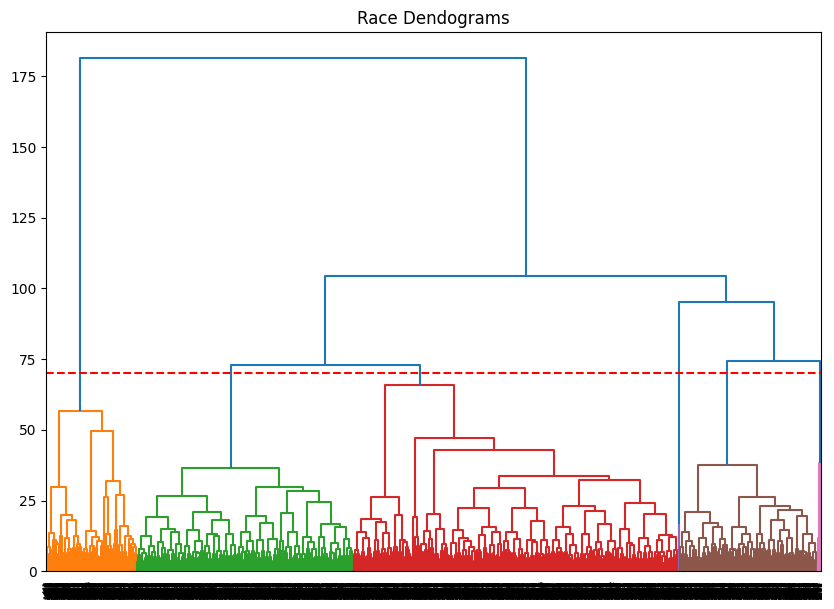

In [21]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import fcluster

# データのサブセットを取得
sample_df = result_df.sample(frac=0.1, random_state=1)

# ダミー変数の作成
sample_df_encoded = pd.get_dummies(sample_df[column_list], drop_first=True)

# 欠損値を0で穴埋め
sample_df_encoded.fillna(0, inplace=True)

# 無限大の値が含まれていないことを確認
if np.any(np.isinf(sample_df_encoded)):
    # 無限大の値がある場合は、適当な数値（例えば NaN）で置換
    sample_df_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)
    # 無限大の値を置換した後に再度欠損値を0で穴埋め
    sample_df_encoded.fillna(0, inplace=True)

# スケーリング
scaler = StandardScaler()
sample_df_scaled = scaler.fit_transform(sample_df_encoded)

# リンケージ行列の計算
linked = shc.linkage(sample_df_scaled, method='ward')

# クラスタラベルの割り当て
clusters = fcluster(linked, t=70, criterion='distance')

# sample_dfにclusterカラムを追加
sample_df['cluster'] = clusters

# グラフの表示
plt.figure(figsize=(10, 7))
plt.title("Race Dendograms")
dend = shc.dendrogram(linked, color_threshold=70)
plt.axhline(y=70, color='r', linestyle='--')
plt.show()


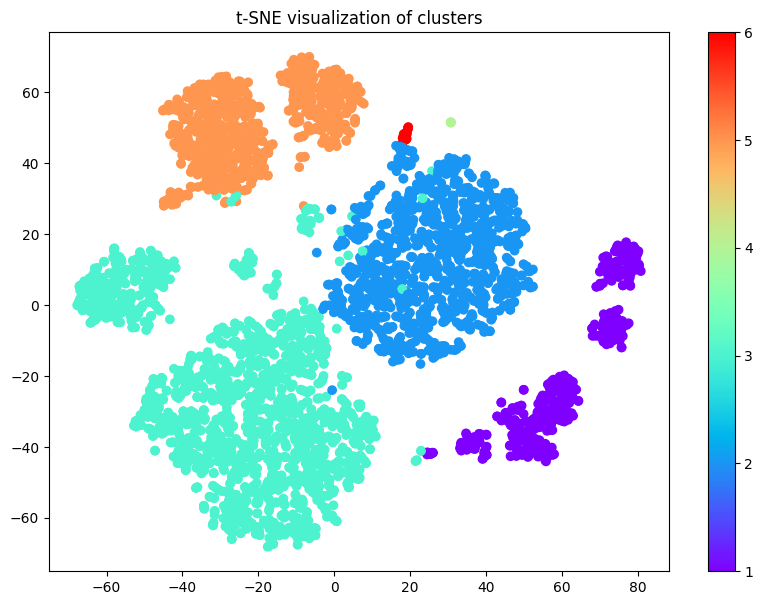

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNEの適用
tsne = TSNE(n_components=2, random_state=42)
sample_df_tsne = tsne.fit_transform(sample_df_scaled)

# 可視化
plt.figure(figsize=(10, 7))
plt.scatter(sample_df_tsne[:, 0], sample_df_tsne[:, 1], c=sample_df['cluster'], cmap='rainbow')
plt.colorbar()
plt.title("t-SNE visualization of clusters")
plt.show()

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


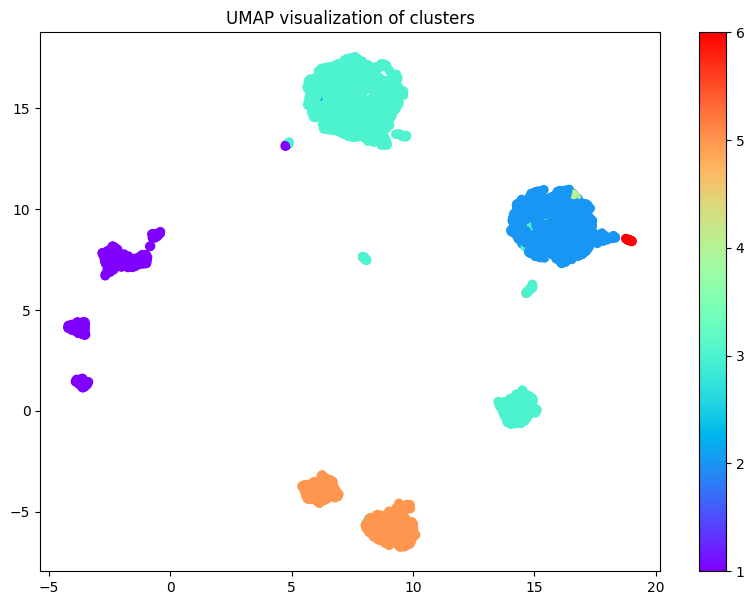

In [23]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# UMAPの適用
reducer = umap.UMAP(random_state=42)
sample_df_umap = reducer.fit_transform(sample_df_scaled)

# 可視化
plt.figure(figsize=(10, 7))
plt.scatter(sample_df_umap[:, 0], sample_df_umap[:, 1], c=sample_df['cluster'], cmap='rainbow')
plt.colorbar()
plt.title("UMAP visualization of clusters")
plt.show()

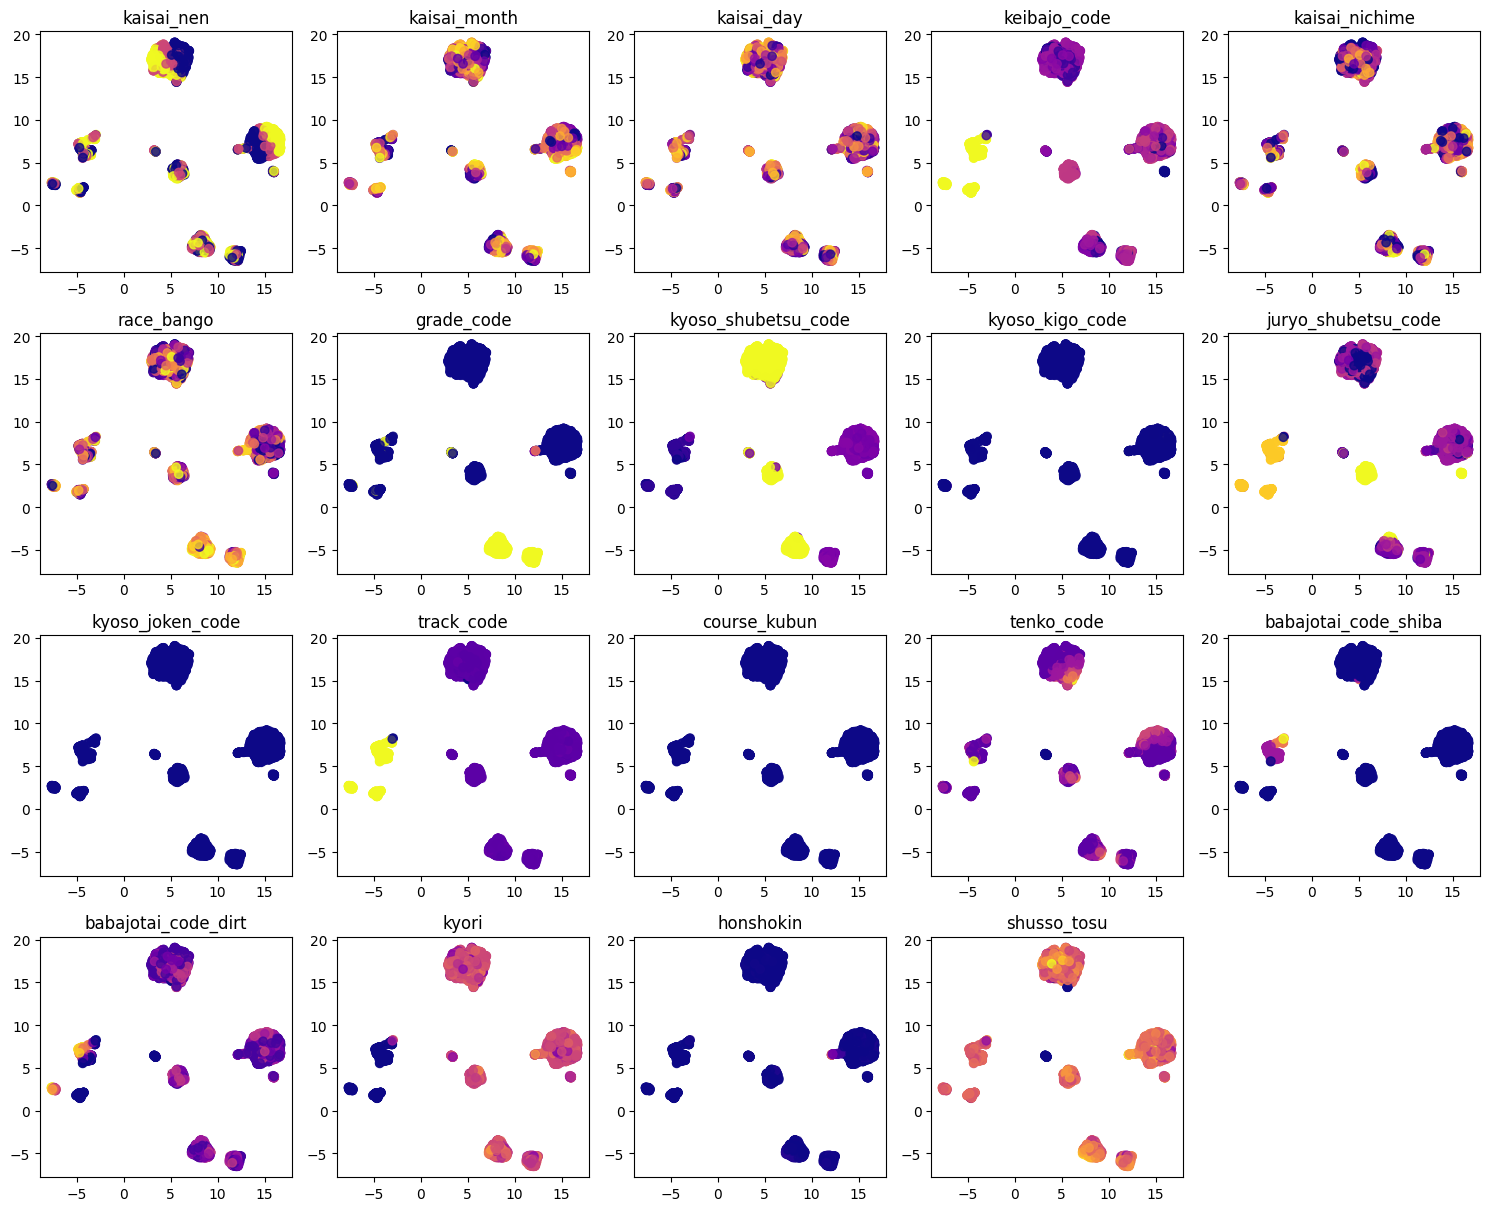

In [24]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(sample_df_scaled)

# 可視化
fig = plt.figure(figsize=(15,15))

for i, col in enumerate(column_list):
    if i >= 25:  # 最大25のサブプロットのみ表示
        break
    ax = fig.add_subplot(5, 5, i+1, title=col)
    ax.scatter(embedding[:, 0], embedding[:, 1],
               c=sample_df_encoded[col], cmap='plasma', alpha=0.8)

fig.tight_layout()
plt.show()

In [25]:
import seaborn as sns

print(sample_df['cluster'].value_counts())

cluster
3    1894
2    1261
5     804
1     529
6      19
4       4
Name: count, dtype: int64


Crosstab result for column: kaisai_nen
kaisai_nen  2020  2021  2022
cluster                     
1            167   172   190
2            412   413   436
3            688   591   615
4              0     3     1
5            263   268   273
6              7     6     6


Crosstab result for column: kaisai_month
kaisai_month   1    2    3    4    5    6    7    8    9    10   11   12
cluster                                                                 
1              51   46   42   24   46   42   56   45   36   56   43   42
2              84   77  110   98  136  142  118  103  130   80   97   86
3             137  101  150  161  187  137  159  157  162  185  173  185
4               0    2    0    0    0    0    0    0    0    0    0    2
5              58   46   60   59   63   61   73   75  102   74   65   68
6               0    1    2    0    1    1    3    2    1    1    6    1


Crosstab result for column: kaisai_day
kaisai_day  1   2   3   4   5   6   7   8   9   10  11  12  1

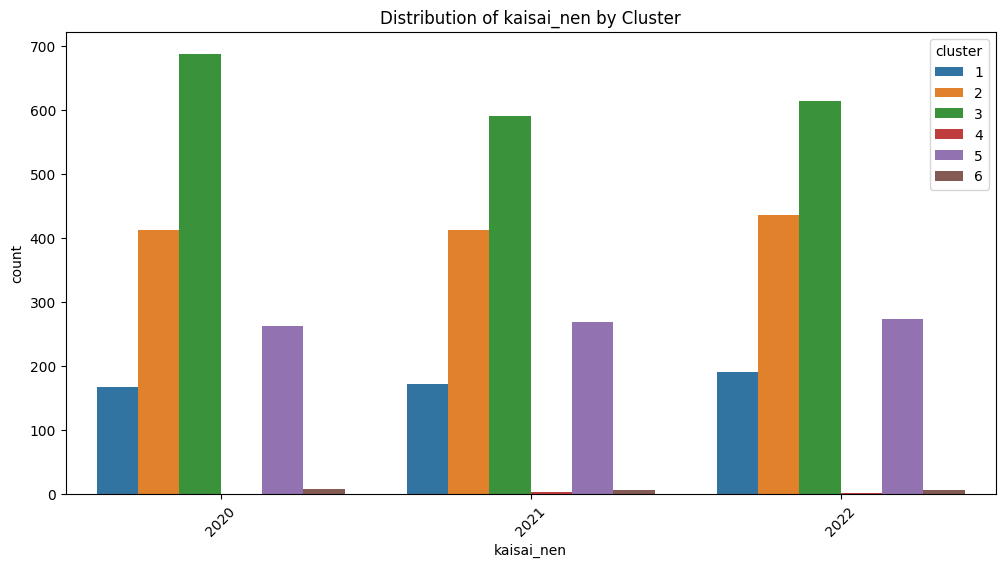

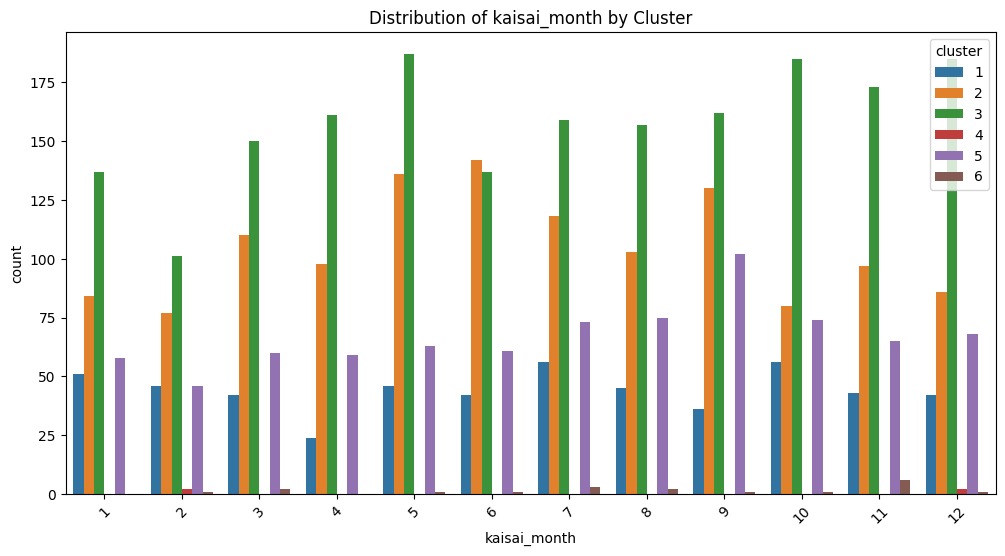

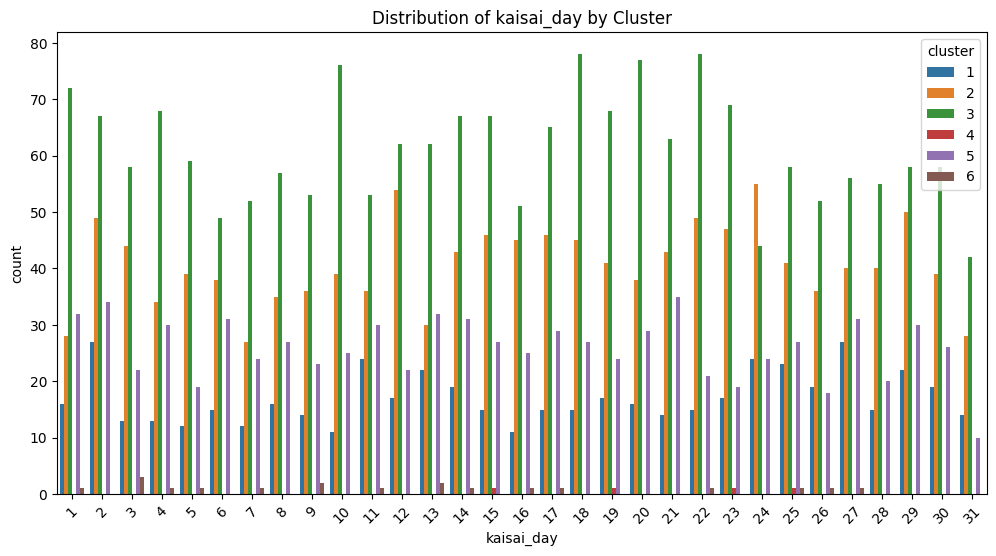

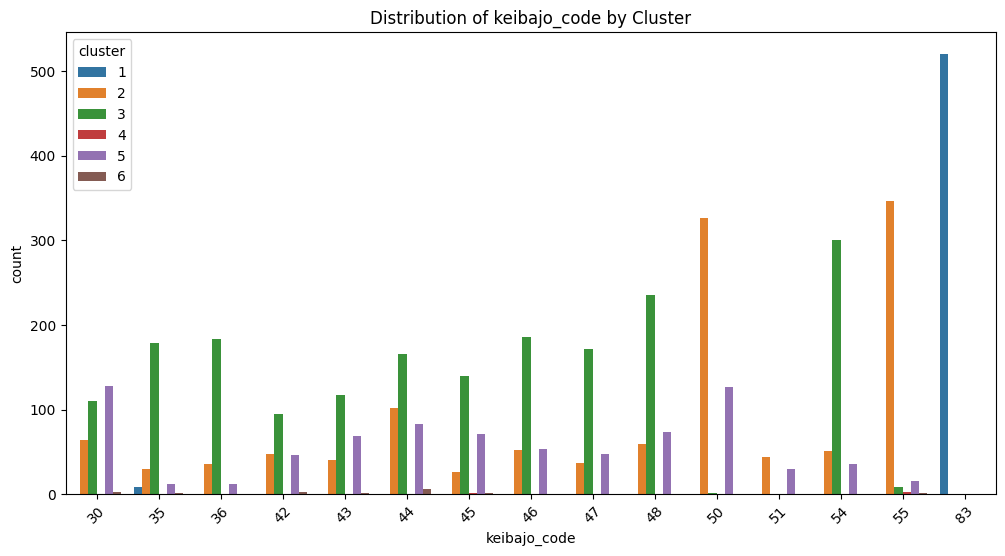

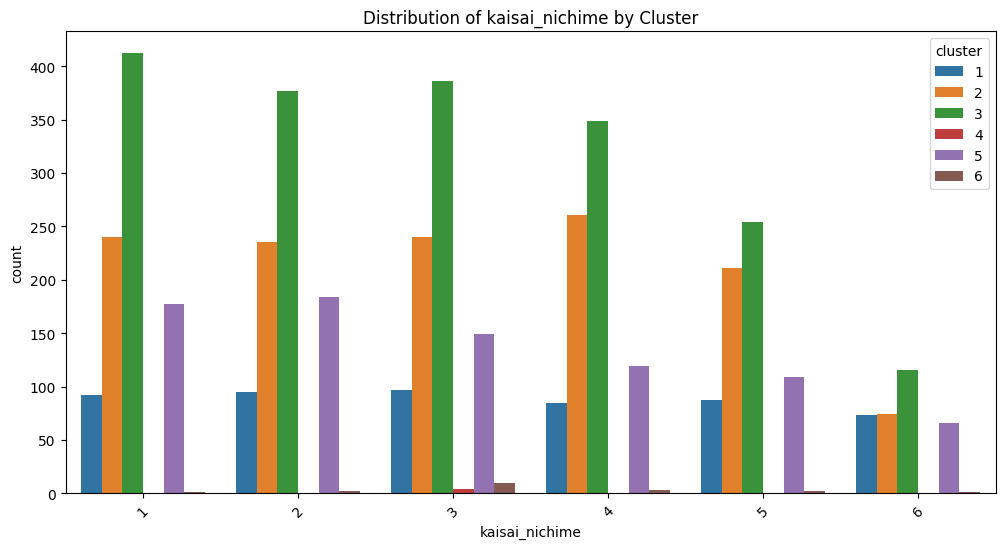

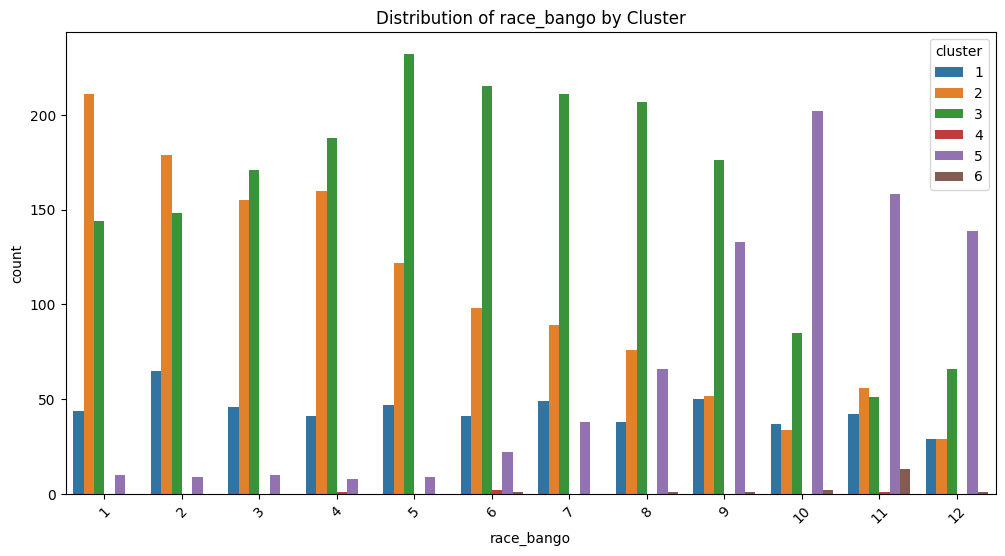

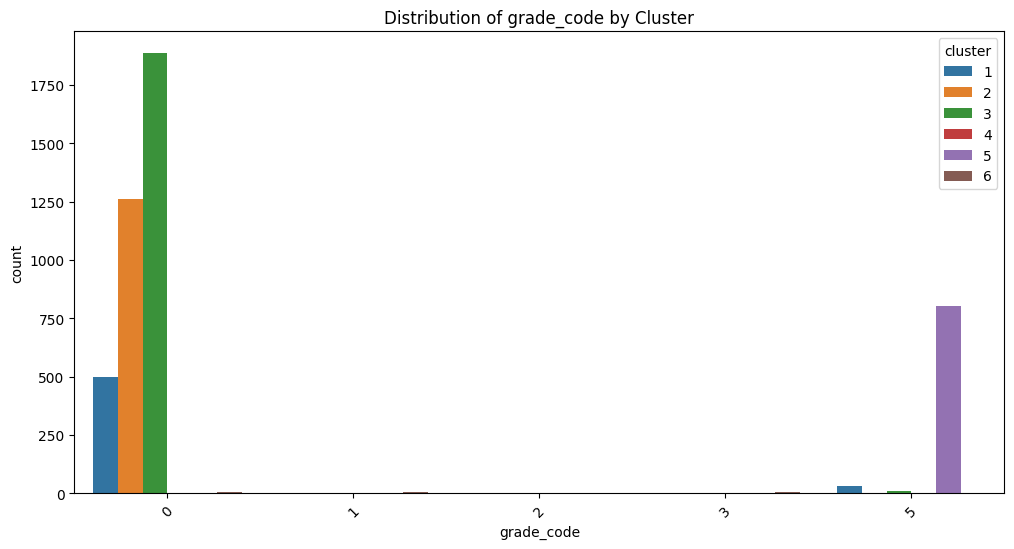

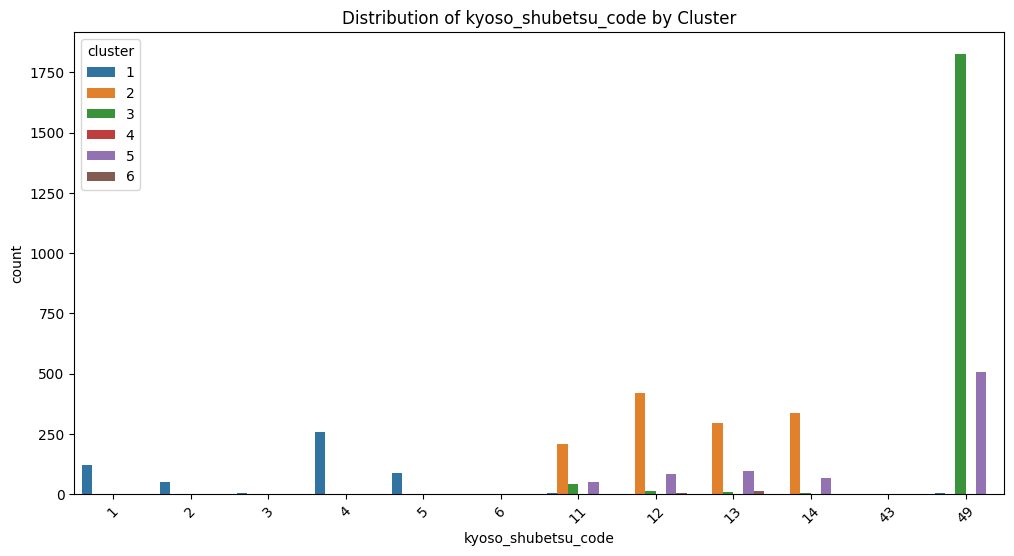

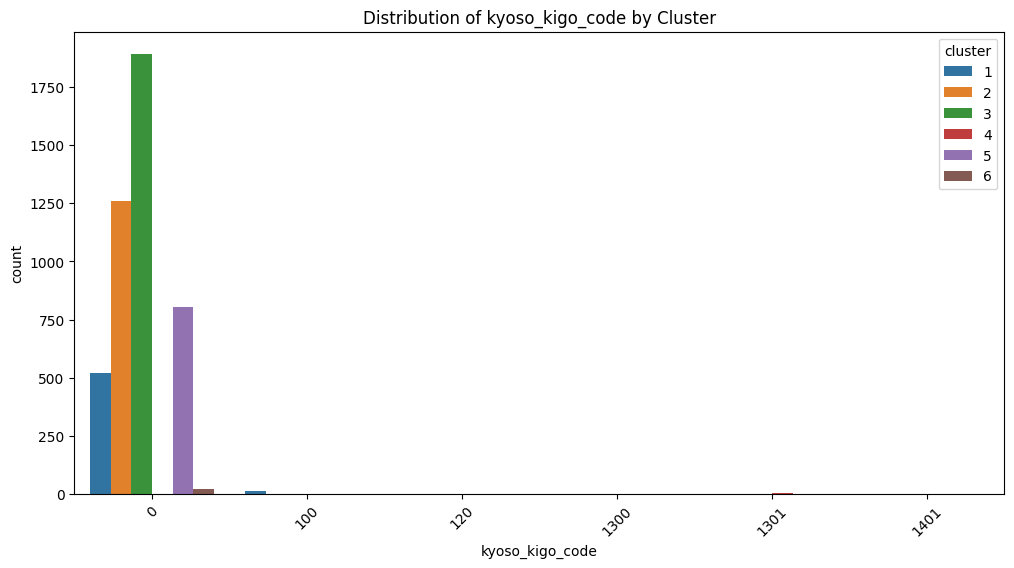

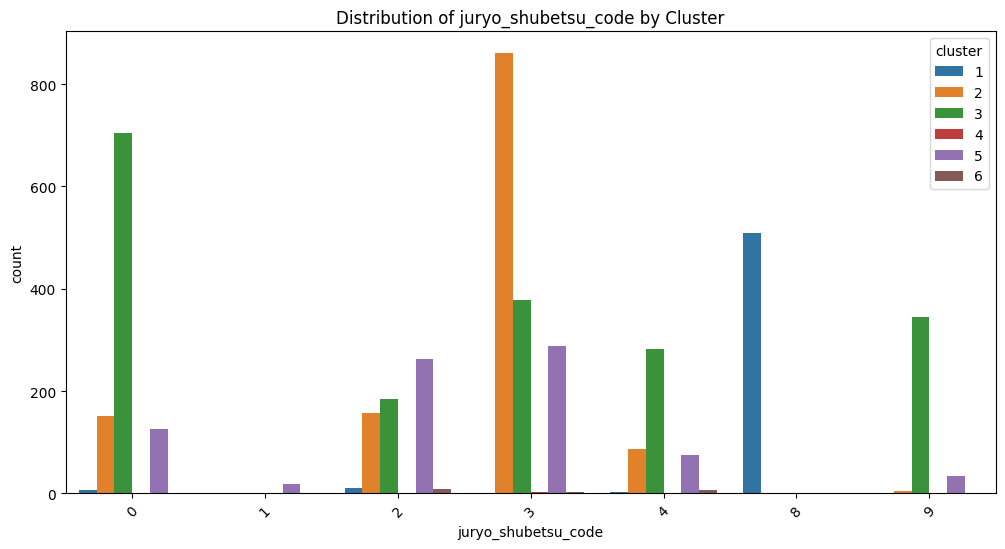

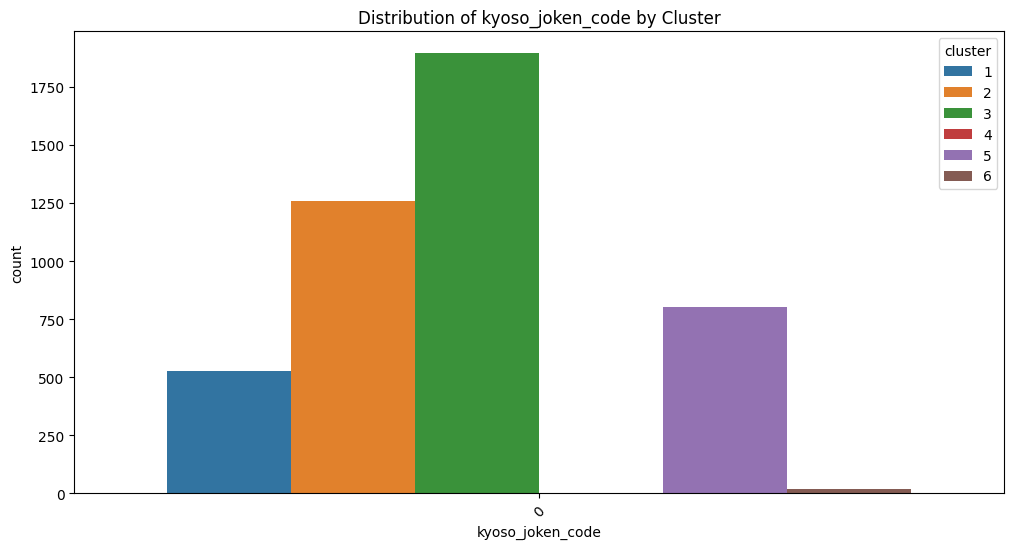

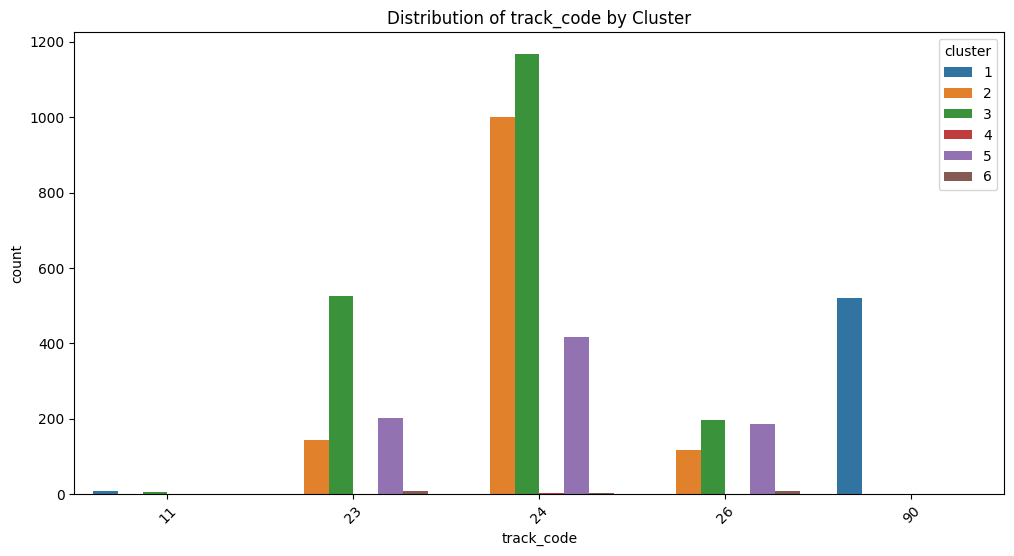

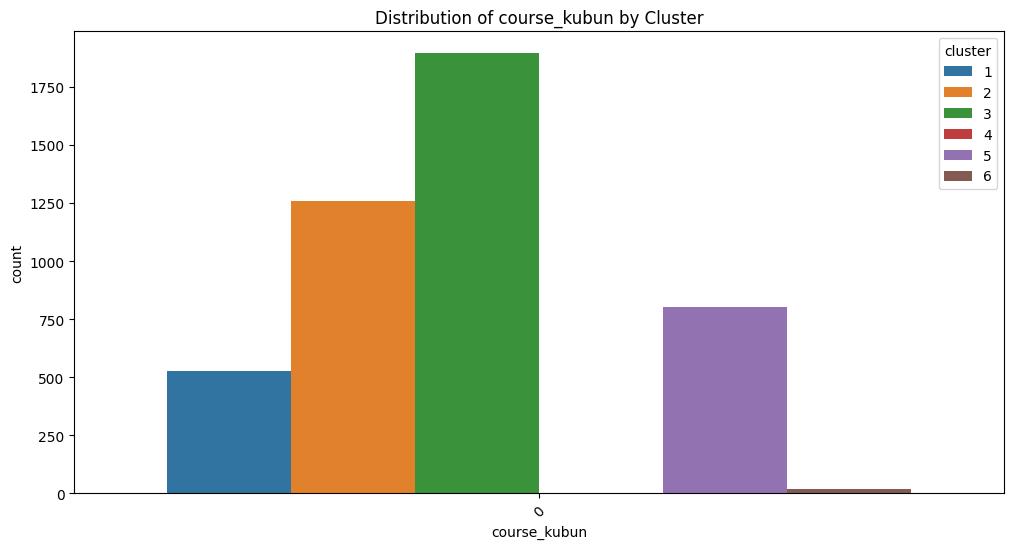

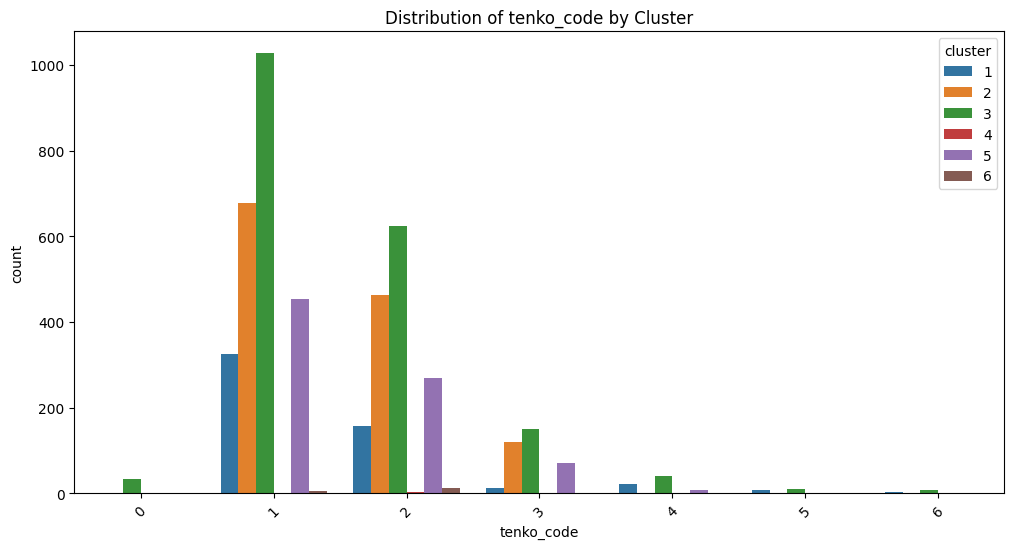

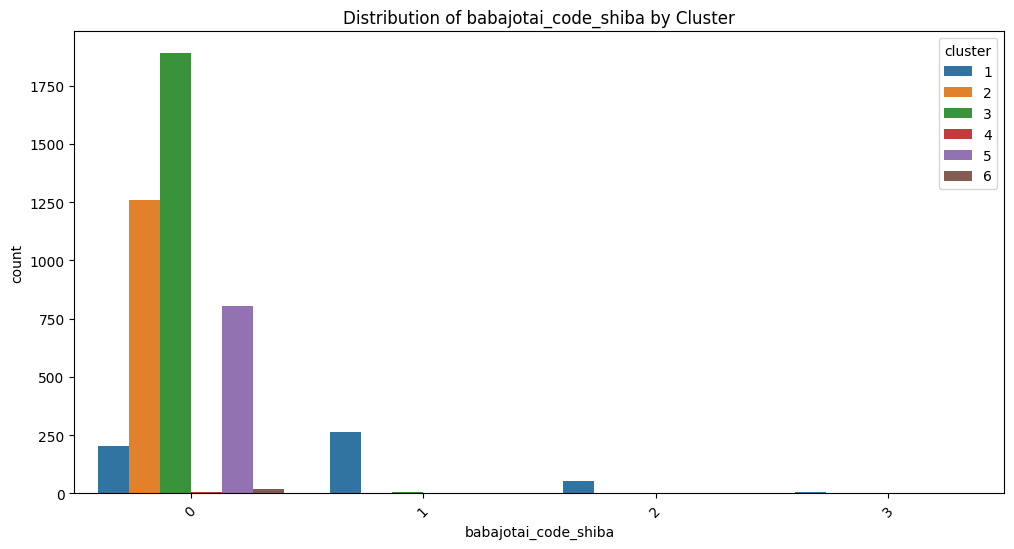

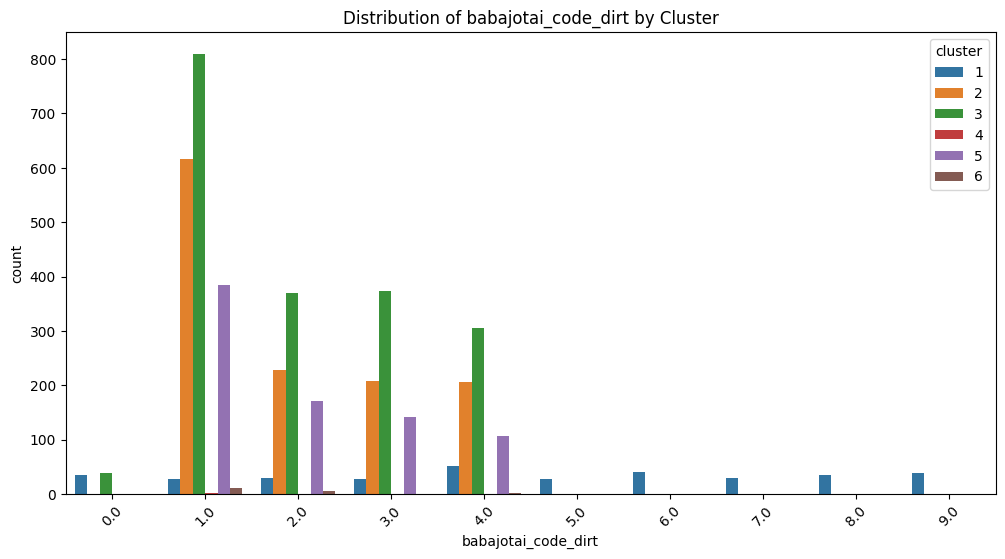

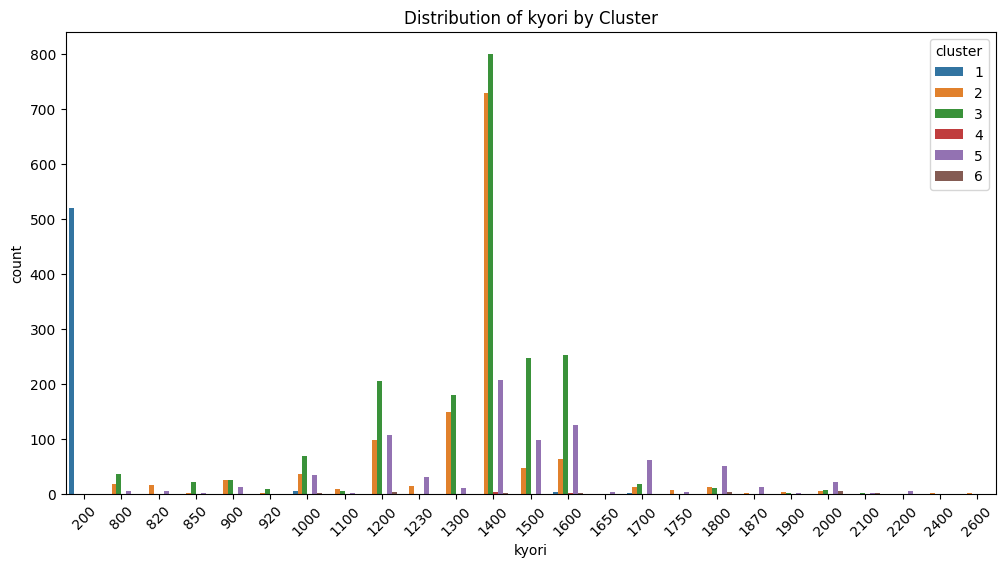

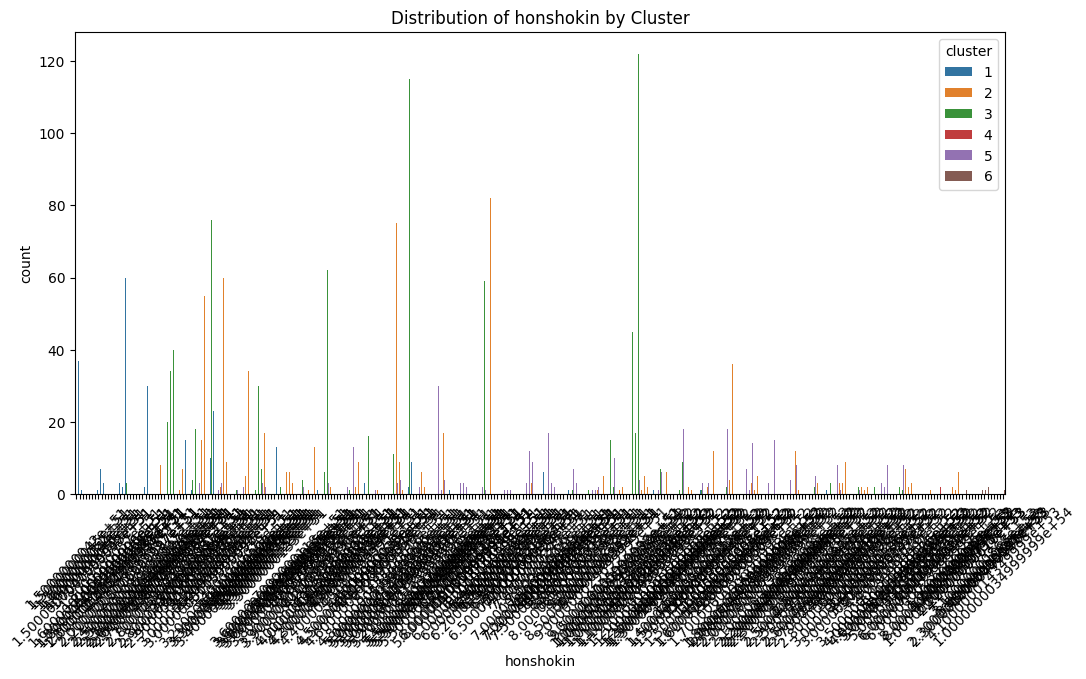

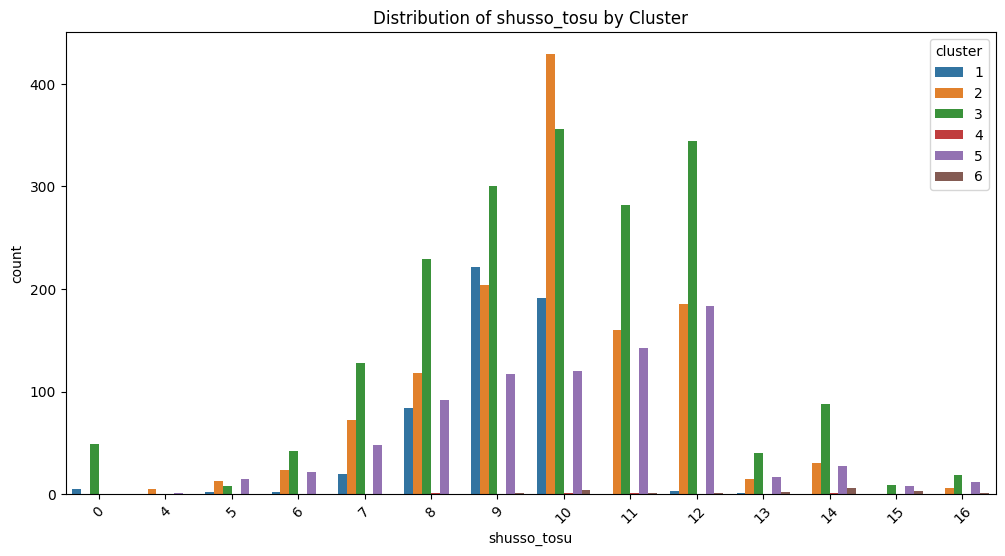

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# クロスタブを用いて各カテゴリカル変数のクラスタ内での分布を確認
for column in column_list:
    crosstab_result = pd.crosstab(sample_df['cluster'], sample_df[column])
    print(f"Crosstab result for column: {column}")
    print(crosstab_result)
    print("\n")

# 棒グラフを用いて可視化
for column in column_list:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=sample_df, x=column, hue='cluster')
    plt.title(f'Distribution of {column} by Cluster')
    plt.xticks(rotation=45)
    plt.show()


In [27]:
average_values = sample_df.groupby('cluster')[['is_correct', 'profit']].mean()

# 結果を表示
print(average_values)

         is_correct       profit
cluster                         
1          0.207940  -255.935728
2          0.249009  -369.222839
3          0.261352  -259.062500
4          0.000000 -1000.000000
5          0.248756  -335.447761
6          0.105263  -755.789474


In [28]:
sample_df

,group,is_correct,profit,kaisai_nen,kaisai_tsukihi,keibajo_code,kaisai_kai,kaisai_nichime,race_bango,yobi_code,jusho_kaiji,grade_code,kyoso_shubetsu_code,kyoso_kigo_code,juryo_shubetsu_code,kyoso_joken_code_2sai,kyoso_joken_code_3sai,kyoso_joken_code_4sai,kyoso_joken_code_5sai_ijo,kyoso_joken_code,kyori,track_code,course_kubun,honshokin,fukashokin,hasso_jikoku,toroku_tosu,shusso_tosu,nyusen_tosu,tenko_code,babajotai_code_shiba,babajotai_code_dirt,kaisai_month,kaisai_day,cluster
21755,2021-320-83-5,0,-1000.0,2021,320,83,26,3,5,3,0,0,5,0,8,0,0,0,0,0,200,90,0,2.200000e+51,0,1615,9,9,9,1,0,9.0,3,20,1
35371,2022-215-51-4,1,7700.0,2022,215,51,4,4,4,5,0,0,14,0,3,0,0,0,0,0,1400,24,0,5.000000e+51,0,1215,12,11,11,2,0,1.0,2,15,2
44286,2022-914-30-4,0,-1000.0,2022,914,30,11,5,4,6,0,0,49,0,3,0,0,0,0,0,1700,26,0,3.000000e+51,0,1610,11,11,11,1,0,1.0,9,14,3
1212,2020-1025-55-4,0,-1000.0,2020,1025,55,13,4,4,2,0,0,13,0,3,0,0,0,0,0,1300,24,0,2.700000e+51,0,1655,8,8,8,1,0,3.0,10,25,2
4228,2020-1219-83-6,1,-200.0,2020,1219,83,18,4,6,1,0,0,4,0,8,0,0,0,0,0,200,90,0,1.600000e+51,0,1650,8,8,8,1,0,NaN,12,19,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6243,2020-304-45-2,0,-1000.0,2020,304,45,14,3,2,6,0,0,49,0,0,0,0,0,0,0,1400,23,0,8.000000e+51,0,1150,12,12,12,2,0,2.0,3,4,3
31912,2022-1108-50-5,0,-1000.0,2022,1108,50,18,1,5,5,0,0,13,0,3,0,0,0,0,0,1400,24,0,6.000000e+51,0,1240,10,10,10,1,0,1.0,11,8,2
15087,2021-1001-48-6,0,-1000.0,2021,1001,48,14,4,6,8,0,0,11,0,3,0,0,0,0,0,1400,24,0,5.200000e+51,0,1335,11,10,10,2,0,1.0,10,1,2
1973,2020-1104-47-6,0,-1000.0,2020,1104,47,11,2,6,6,0,0,49,0,3,0,0,0,0,0,1600,24,0,2.400000e+51,0,1335,8,8,8,1,0,1.0,11,4,3


In [29]:
# 予測を実行
predictions = loaded_model.predict(merged_df[features])

# 予測結果を'y_pred'列としてtest_dataに追加
merged_df.loc[:, 'y_pred'] = predictions

In [30]:
merged_df.loc[:, 'predicted_rank'] = merged_df.groupby('group')['y_pred'].rank(ascending=False, method='min')

In [31]:
def check_top3_in_top5_predictions(group):
    predicted_top5 = group.nsmallest(5, 'predicted_rank').index.tolist()
    actual_top3 = group.nsmallest(3, 'kakutei_chakujun').index.tolist()
    return all([horse in predicted_top5 for horse in actual_top3])

def calculate_group_profit(group):
    if check_top3_in_top5_predictions(group):
        payout_value = group['haraimodoshi_sanrenpuku_1b'].iloc[0]
        return payout_value - 1000
    else:
        return -1000
is_correct_df = merged_df.groupby('group').apply(check_top3_in_top5_predictions).reset_index(name='is_correct')
profit_df = merged_df.groupby('group').apply(calculate_group_profit).reset_index(name='profit')
result_df = is_correct_df.merge(profit_df, on='group', how='left')

In [32]:
result_df = result_df.merge(n_race_df, on='group', how='left')

In [33]:
result_df['is_correct'] = result_df['is_correct'].astype(int)

In [34]:
# 月日の変換
result_df['kaisai_tsukihi'] = result_df['kaisai_tsukihi'].astype(str)
result_df['kaisai_month'] = result_df['kaisai_tsukihi'].str[:-2].astype(int)
result_df['kaisai_day'] = result_df['kaisai_tsukihi'].str[-2:].astype(int)

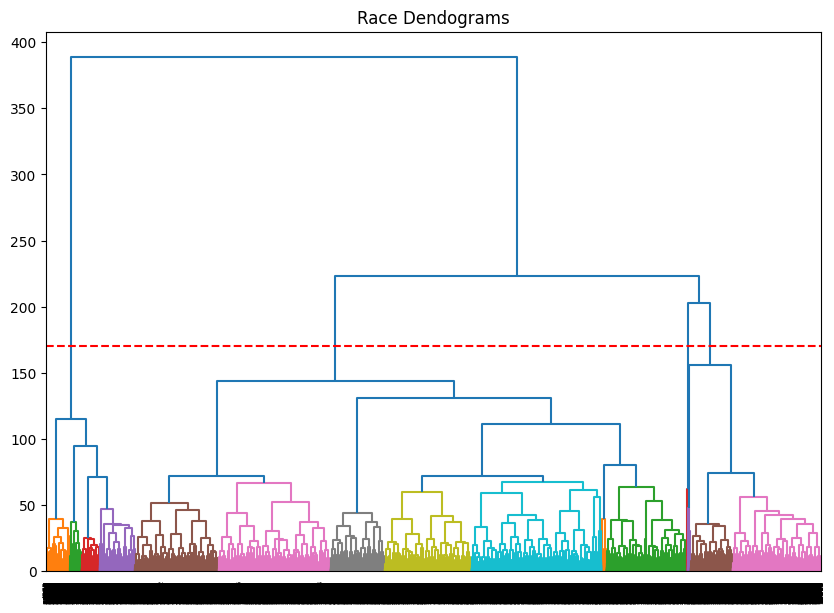

In [60]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import fcluster

# データのサブセットを取得
sample_df = result_df.sample(frac=0.1, random_state=1)

# ダミー変数の作成
sample_df_encoded = pd.get_dummies(sample_df[column_list], drop_first=True)

# 欠損値を0で穴埋め
sample_df_encoded.fillna(0, inplace=True)

# 無限大の値が含まれていないことを確認
if np.any(np.isinf(sample_df_encoded)):
    # 無限大の値がある場合は、適当な数値（例えば NaN）で置換
    sample_df_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)
    # 無限大の値を置換した後に再度欠損値を0で穴埋め
    sample_df_encoded.fillna(0, inplace=True)

# スケーリング
scaler = StandardScaler()
sample_df_scaled = scaler.fit_transform(sample_df_encoded)

# リンケージ行列の計算
linked = shc.linkage(sample_df_scaled, method='ward')

# クラスタラベルの割り当て
clusters = fcluster(linked, t=170, criterion='distance')

# sample_dfにclusterカラムを追加
sample_df['cluster'] = clusters

# グラフの表示
plt.figure(figsize=(10, 7))
plt.title("Race Dendograms")
dend = shc.dendrogram(linked, color_threshold=70)
plt.axhline(y=170, color='r', linestyle='--')
plt.show()


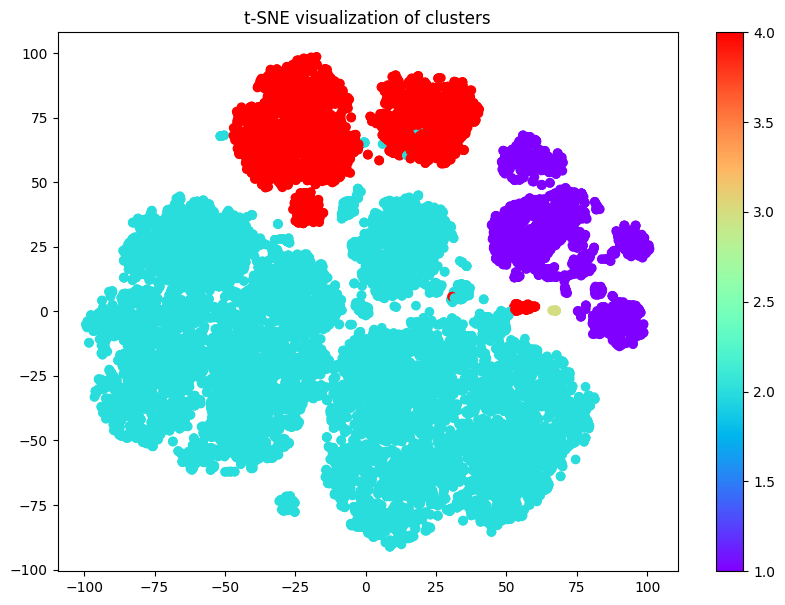

In [61]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNEの適用
tsne = TSNE(n_components=2, random_state=42)
sample_df_tsne = tsne.fit_transform(sample_df_scaled)

# 可視化
plt.figure(figsize=(10, 7))
plt.scatter(sample_df_tsne[:, 0], sample_df_tsne[:, 1], c=sample_df['cluster'], cmap='rainbow')
plt.colorbar()
plt.title("t-SNE visualization of clusters")
plt.show()

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


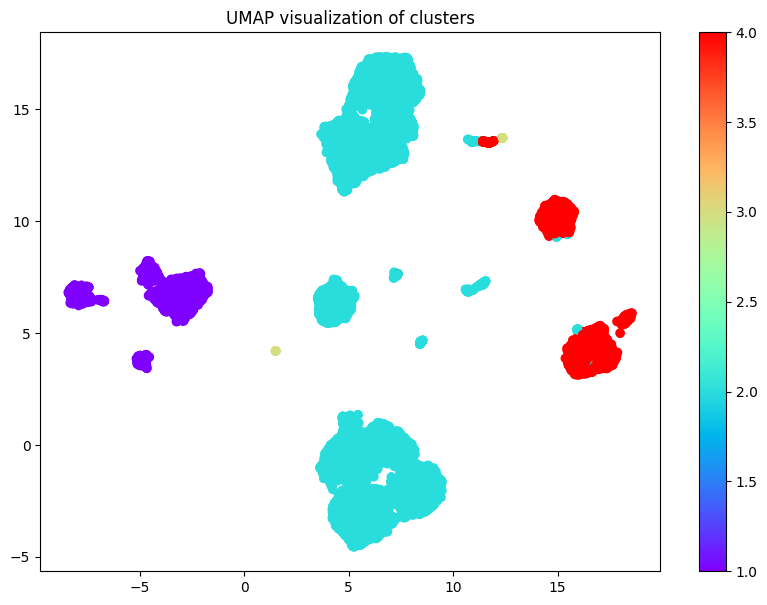

In [62]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# UMAPの適用
reducer = umap.UMAP(random_state=42)
sample_df_umap = reducer.fit_transform(sample_df_scaled)

# 可視化
plt.figure(figsize=(10, 7))
plt.scatter(sample_df_umap[:, 0], sample_df_umap[:, 1], c=sample_df['cluster'], cmap='rainbow')
plt.colorbar()
plt.title("UMAP visualization of clusters")
plt.show()

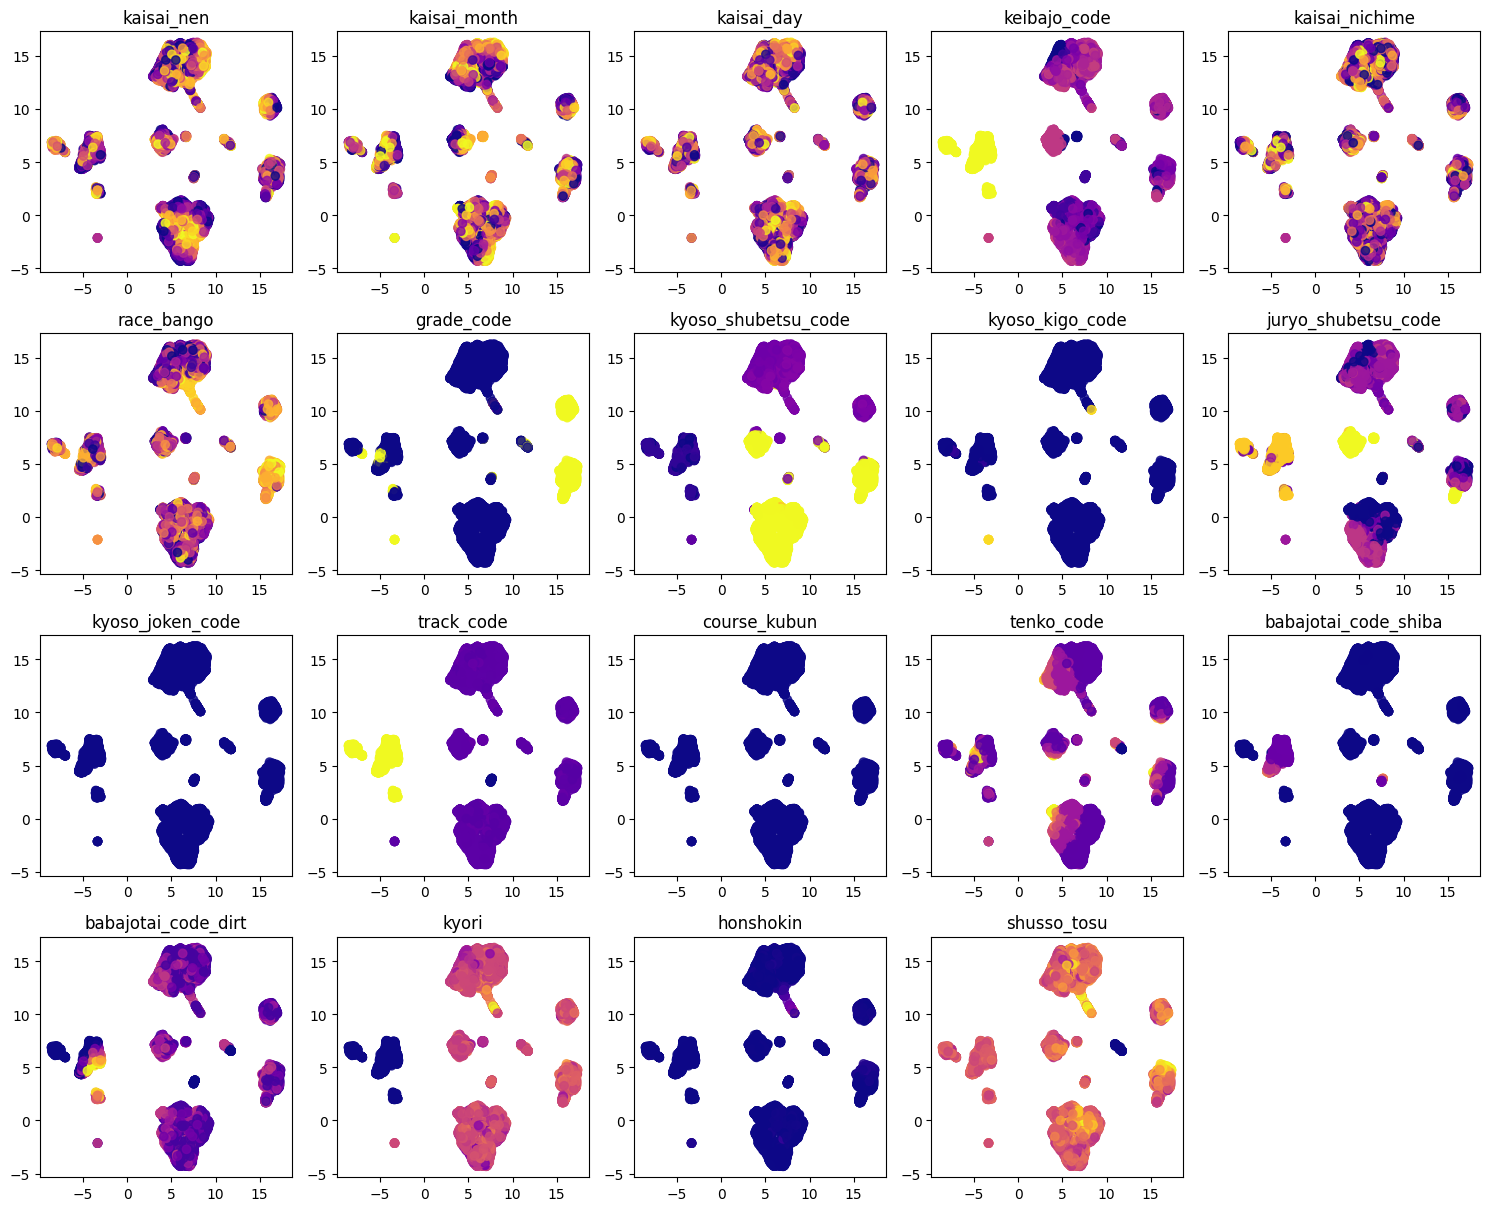

In [38]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(sample_df_scaled)

# 可視化
fig = plt.figure(figsize=(15,15))

for i, col in enumerate(column_list):
    if i >= 25:  # 最大25のサブプロットのみ表示
        break
    ax = fig.add_subplot(5, 5, i+1, title=col)
    ax.scatter(embedding[:, 0], embedding[:, 1],
               c=sample_df_encoded[col], cmap='plasma', alpha=0.8)

fig.tight_layout()
plt.show()

In [39]:
import seaborn as sns

print(sample_df['cluster'].value_counts())

cluster
2    14629
4     3526
1     2362
3       15
Name: count, dtype: int64


Crosstab result for column: kaisai_nen
kaisai_nen  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  \
cluster                                                                        
1            182   199   190   177   172   172   169   157   176   179   131   
2           1160  1164  1119  1061  1042  1062  1022  1105  1070  1039  1049   
3              1     2     0     0     3     2     1     1     0     2     0   
4            262   235   246   236   211   231   254   256   262   257   291   

kaisai_nen  2021  2022  2023  
cluster                       
1            166   170   122  
2            994  1044   698  
3              1     1     1  
4            265   312   208  


Crosstab result for column: kaisai_month
kaisai_month    1    2     3     4     5     6     7     8     9     10    11  \
cluster                                                                         
1              244  211   175    86   199   200   222   204   182   210   209   
2       

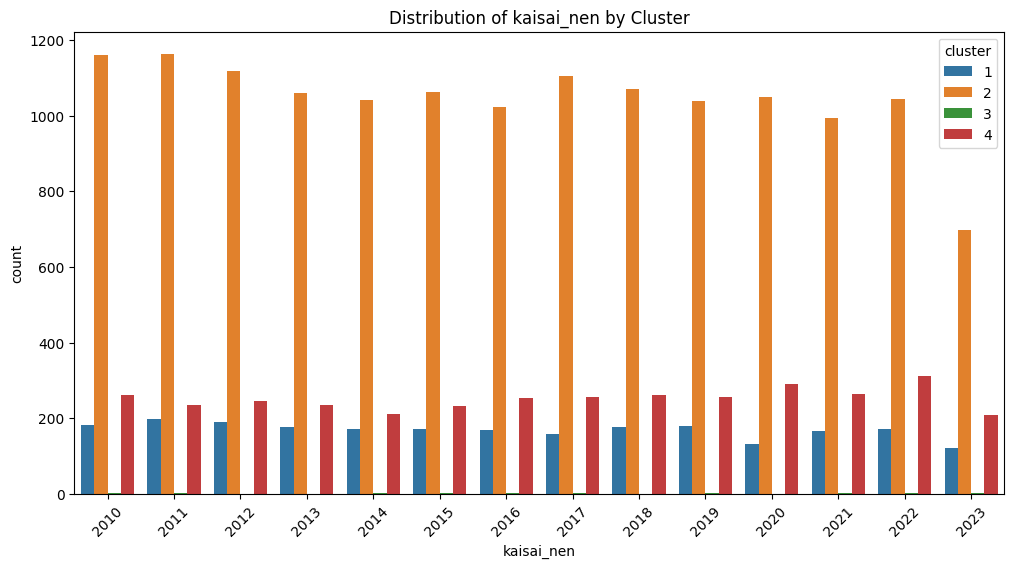

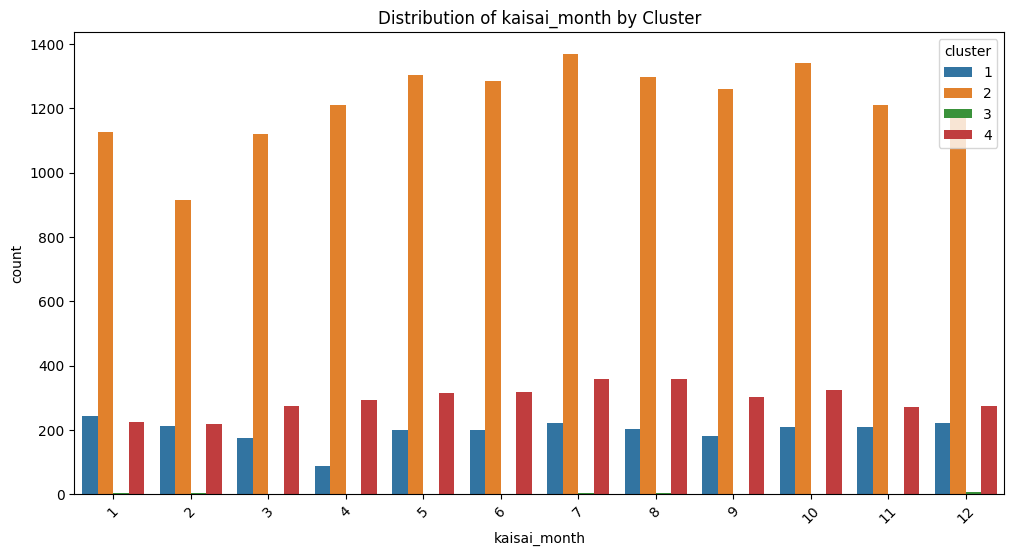

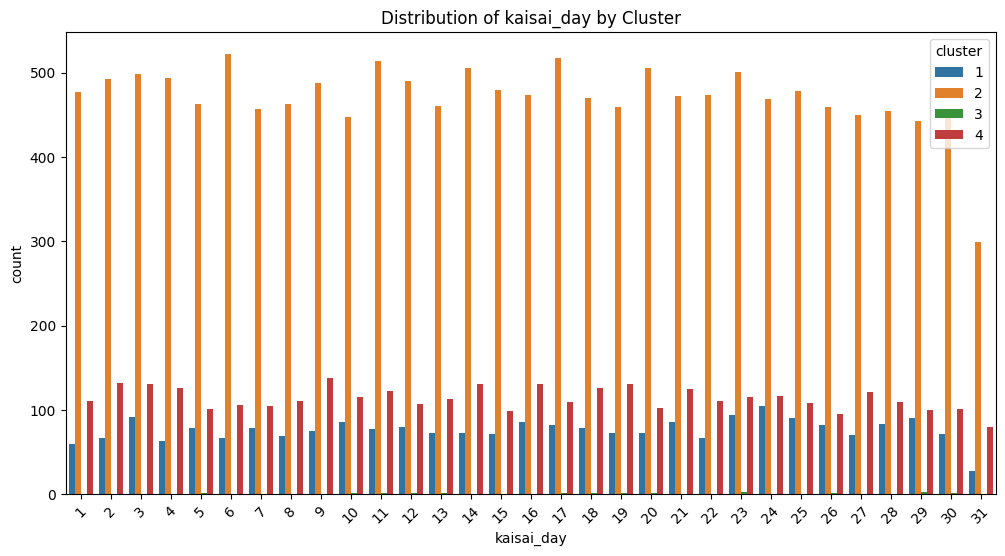

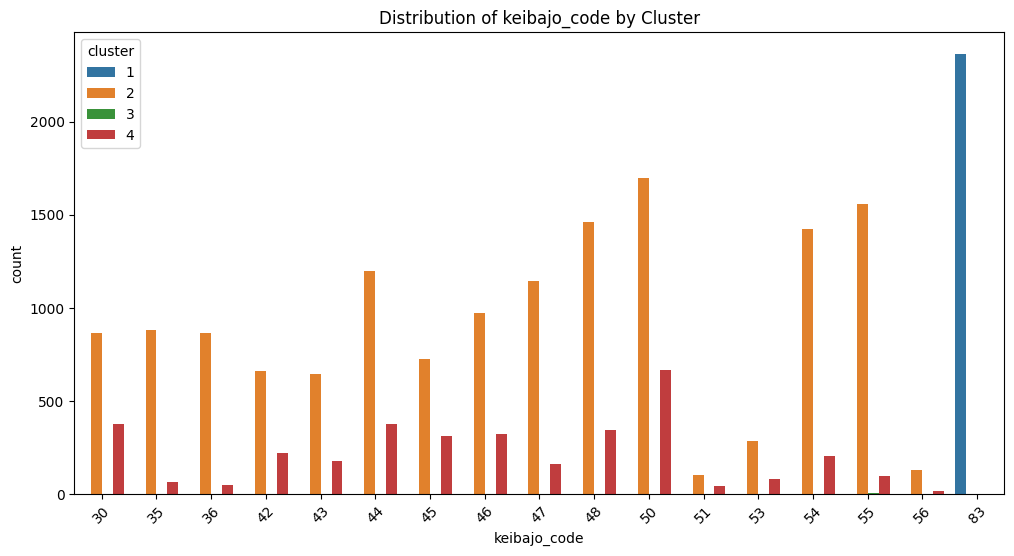

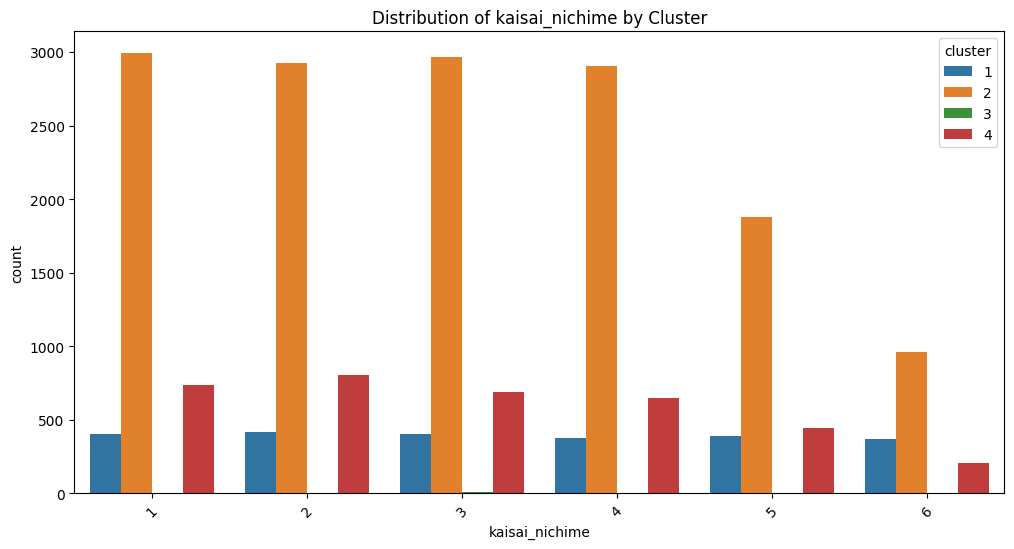

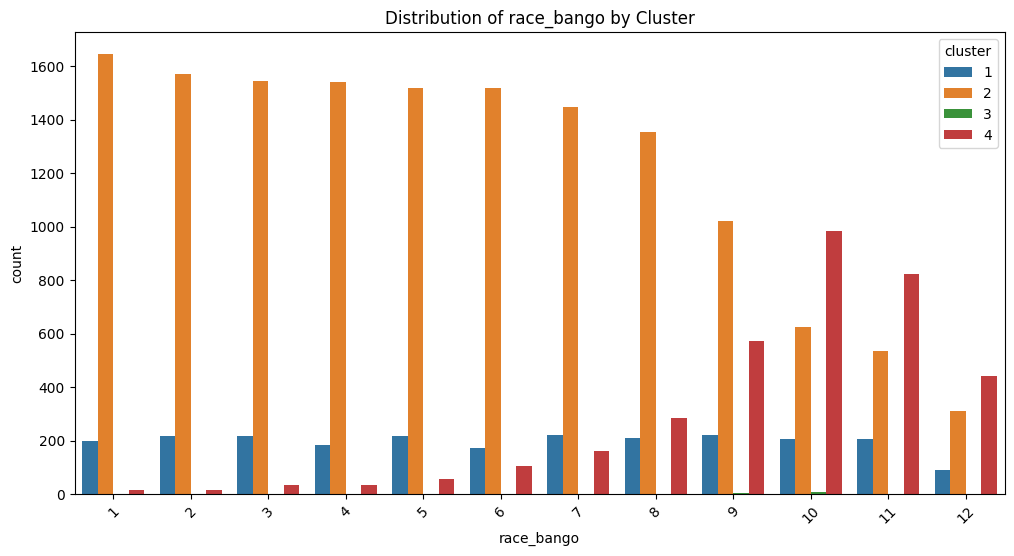

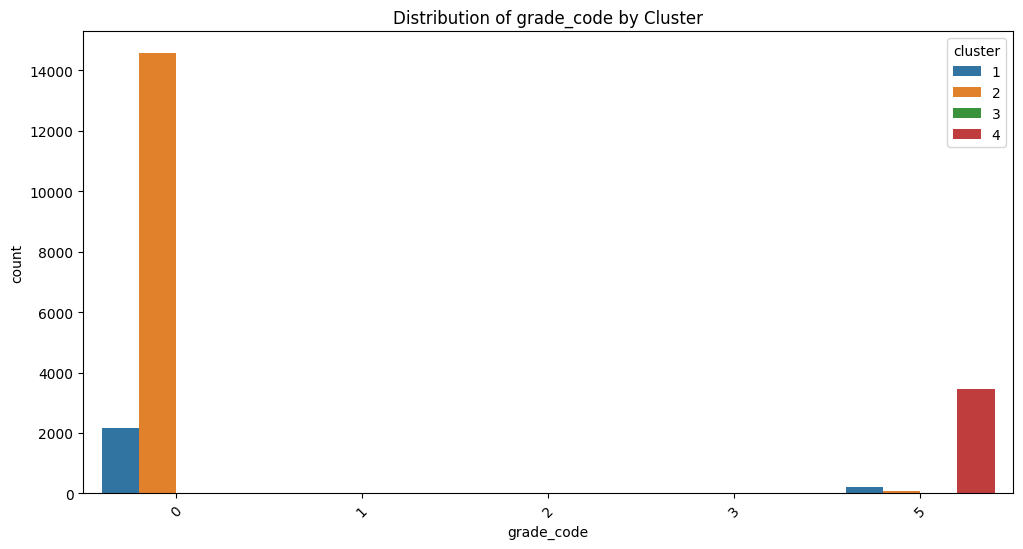

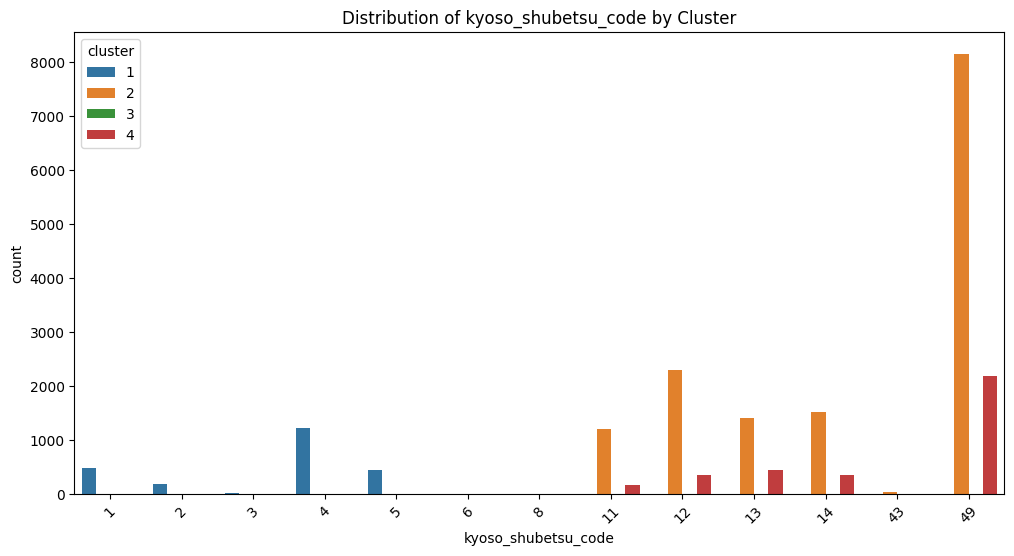

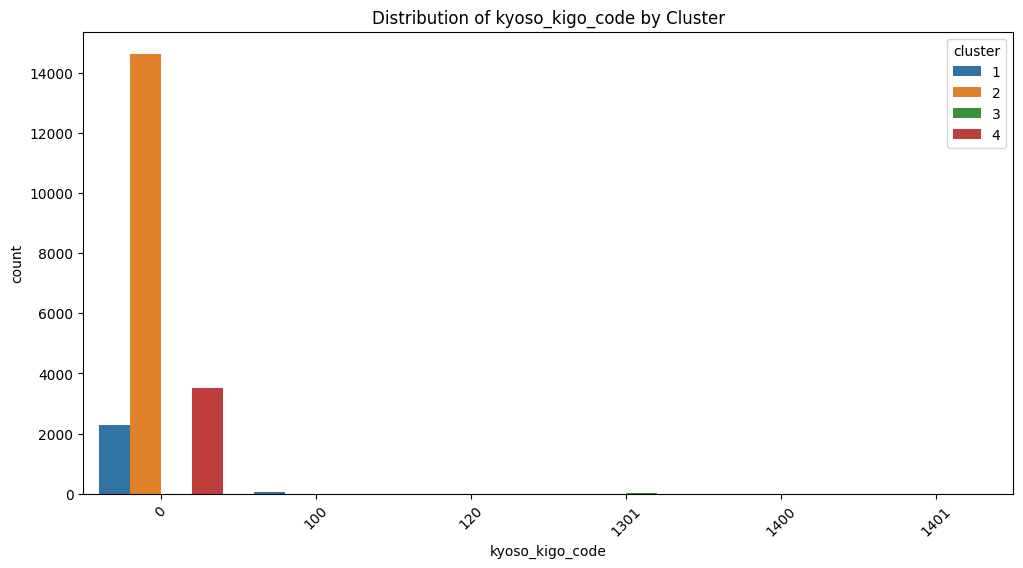

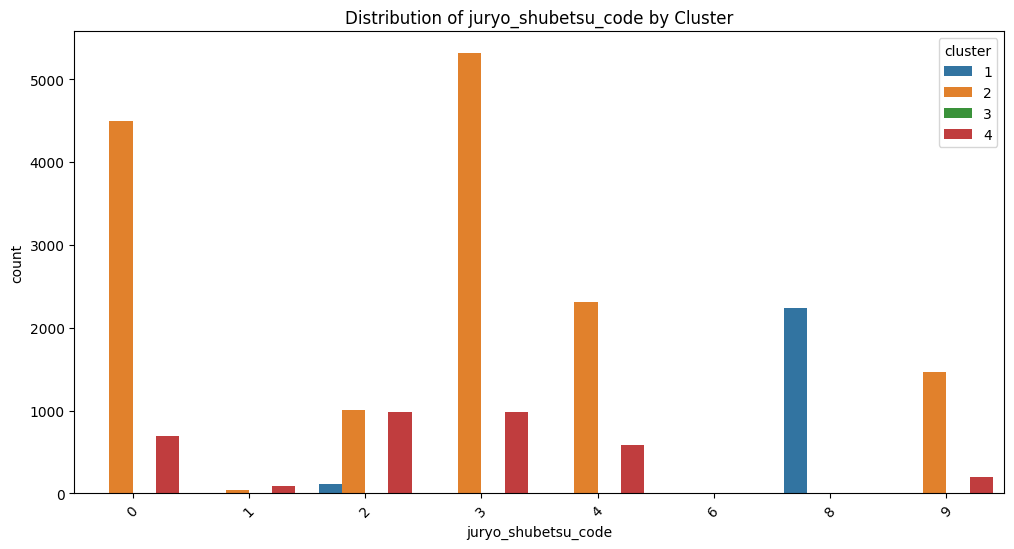

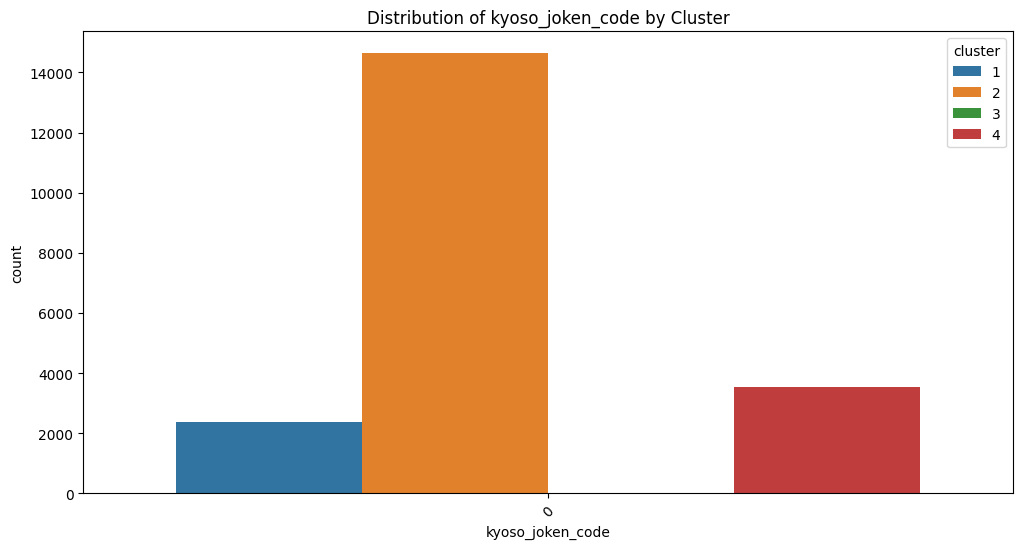

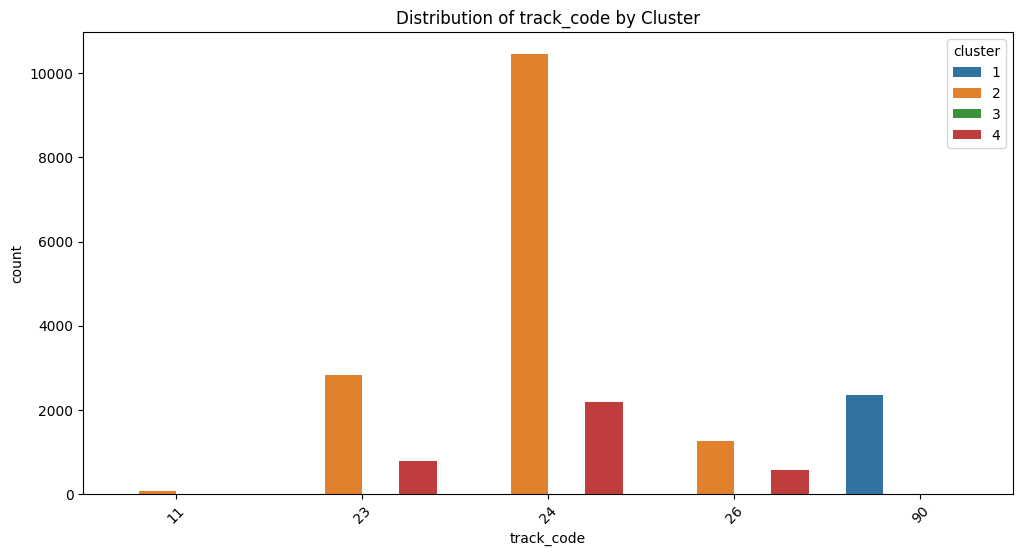

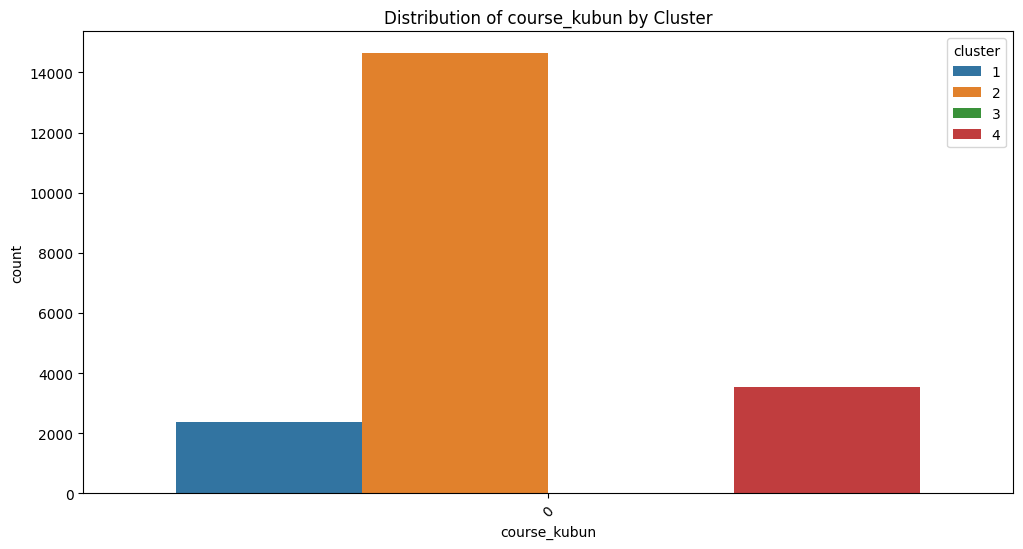

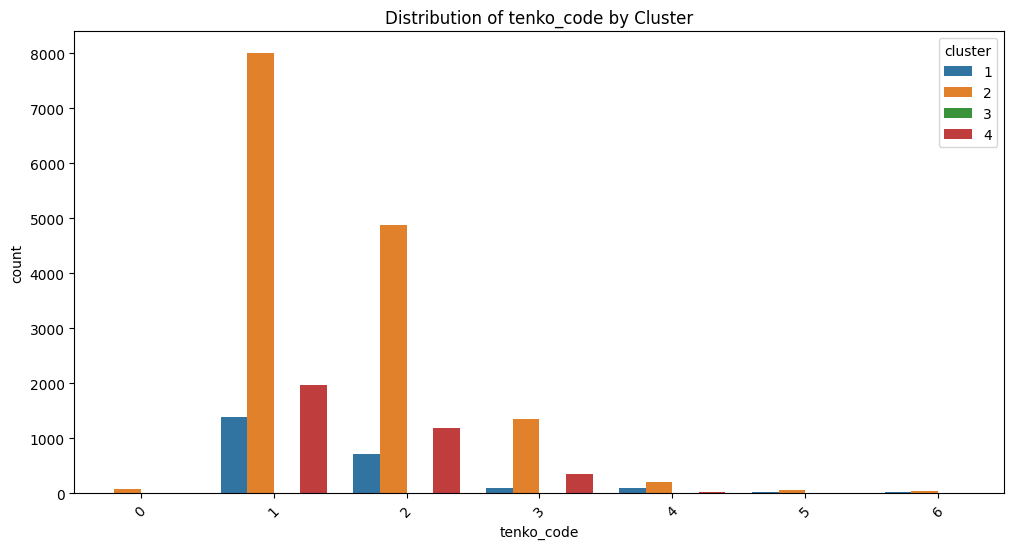

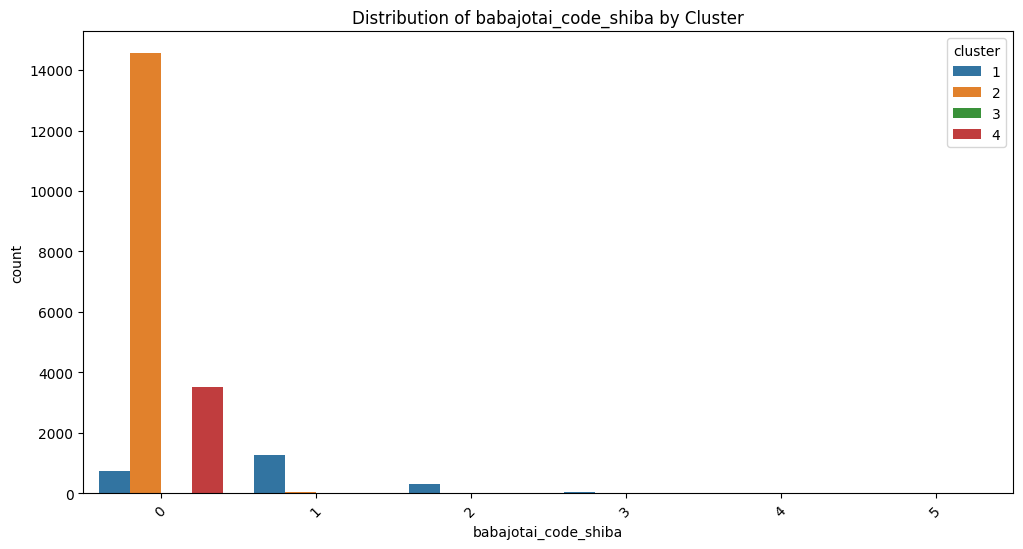

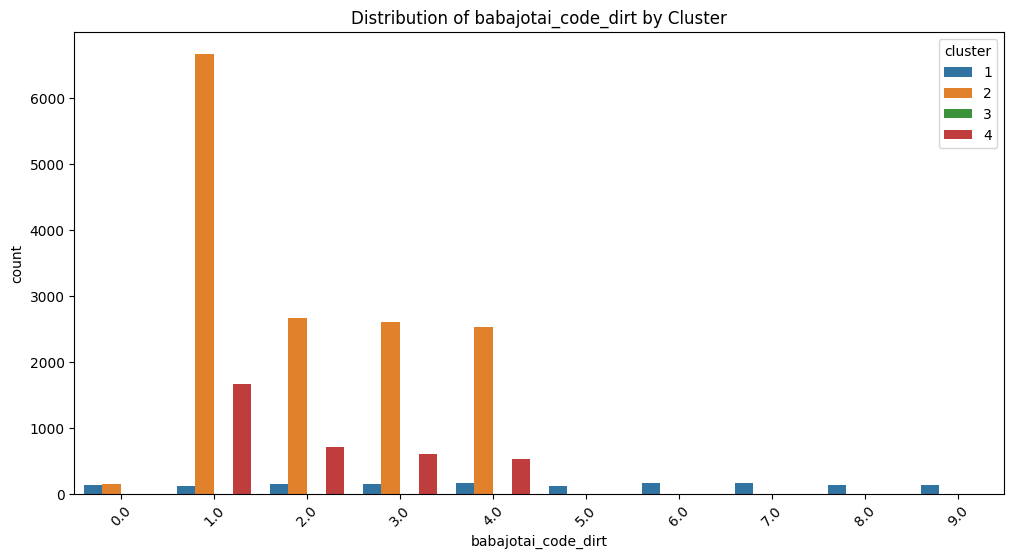

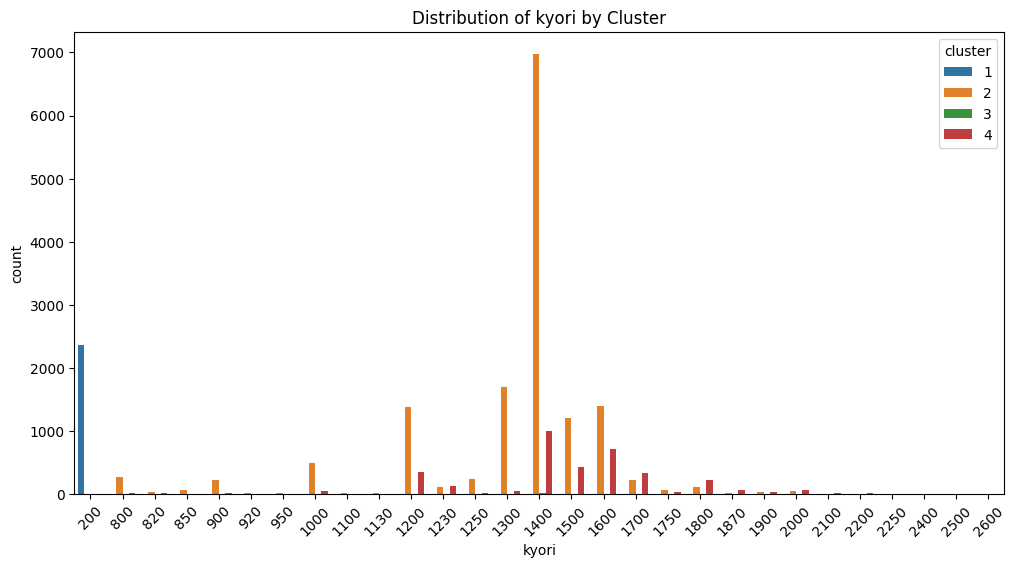

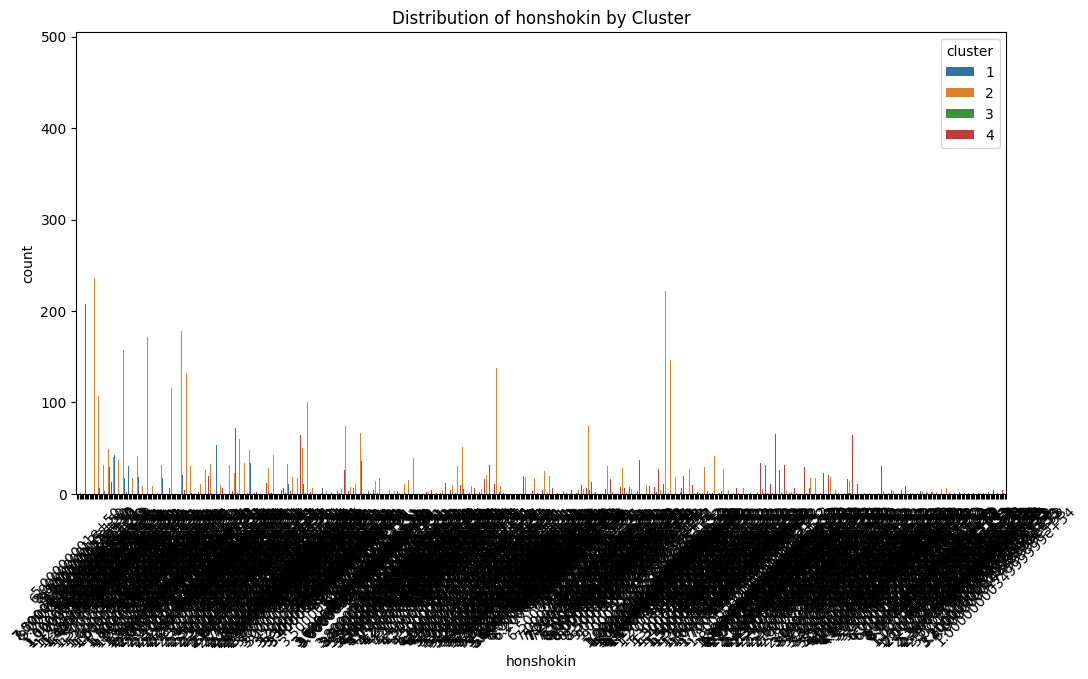

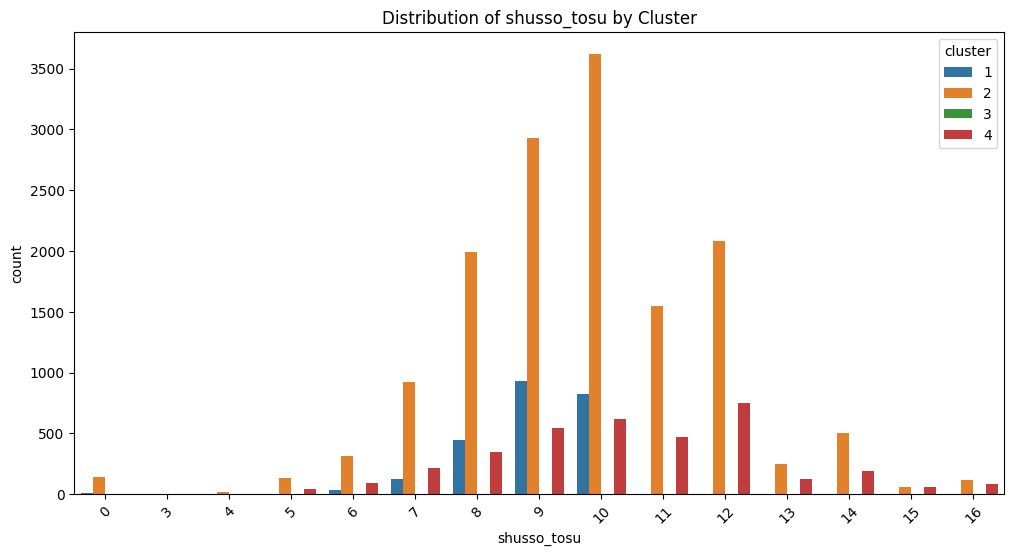

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# クロスタブを用いて各カテゴリカル変数のクラスタ内での分布を確認
for column in column_list:
    crosstab_result = pd.crosstab(sample_df['cluster'], sample_df[column])
    print(f"Crosstab result for column: {column}")
    print(crosstab_result)
    print("\n")

# 棒グラフを用いて可視化
for column in column_list:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=sample_df, x=column, hue='cluster')
    plt.title(f'Distribution of {column} by Cluster')
    plt.xticks(rotation=45)
    plt.show()


In [41]:
average_values = sample_df.groupby('cluster')[['is_correct', 'profit']].mean()

# 結果を表示
print(average_values)

         is_correct      profit
cluster                        
1          0.198561 -437.861147
2          0.280060 -312.729015
3          0.200000 -840.000000
4          0.252411 -331.114894


In [42]:
selected_cluster = 2
groups_in_selected_cluster = sample_df[sample_df['cluster'] == selected_cluster]['group'].unique()

In [43]:
filtered_merged_df = merged_df[merged_df['group'].isin(groups_in_selected_cluster)]

In [44]:
# ndcgの計算
def ndcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    
    gain = 2 ** y_true - 1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def mean_ndcg_score(y_true, y_score, groups, k=5):
    ndcgs = []
    idx_start = 0
    for group in groups:
        ndcgs.append(ndcg_score(y_true[idx_start:idx_start+group], y_score[idx_start:idx_start+group], k))
        idx_start += group
    return np.mean(ndcgs)

In [45]:
def assign_labels(ranking_data):
    '''
    入賞かどうかを判断するカラム'label'を作成
    
    入賞馬（上位三頭）にラベル1を付与する。それ以外は0を付与するコード
    '''
    ranking_data['label'] = 0
    ranking_data.loc[ranking_data['kakutei_chakujun'] <= 3, 'label'] = 1

In [46]:
assign_labels(filtered_merged_df)

C:\Users\kawam\AppData\Local\Temp\ipykernel_3556\2875152387.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ranking_data['label'] = 0


In [47]:
# サンプリング
'''
'label'に応じて、sample_weightsを変更するコード

入賞馬のデータをそれ以外のもの2倍多くサンプリングしやすいように重みを変更する
'''
y_true = filtered_merged_df['label'].values
sample_weights = np.where(y_true == 1, 2.0, 1.0)

In [48]:
# カスタム損失関数
PENALTY_TERM = 1

def custom_loss(y_pred, train_data):
    '''
    勾配にペナルティーを付けるコード

    予測の上位5頭の内に実際の入賞馬がいないと勾配を大きくする
    勾配が大きいほどパラメータの更新量も大きくなるので
    '''
    y_true = train_data.get_label()
    grad = 2 * (y_pred - y_true)
    hess = 2 * np.ones_like(y_true)
    
    top5_indices = np.argsort(y_pred)[-5:]
    if np.sum(y_true[top5_indices] == 1) == 0:
        grad[top5_indices] += PENALTY_TERM
    return grad, hess

In [49]:
# 再ランキング
def rerank_predictions(y_true, y_pred):
    '''
    
    '''
    top5_indices = np.argsort(y_pred)[-5:]
    if np.sum(y_true[top5_indices] == 1) < 3:
        one_indices = np.where(y_true == 1)[0]
        for idx in one_indices:
            if idx not in top5_indices:
                top5_indices[-1] = idx
                break
    return top5_indices

In [50]:
train_data = filtered_merged_df[filtered_merged_df['kaisai_nen'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
test_data = filtered_merged_df[filtered_merged_df['kaisai_nen'].isin([2020, 2021, 2022])]

In [51]:
group_sizes = train_data.groupby('group').size()

def objective(trial):
    # Optuna parameters
    params = {
        'objective': None,
        'metric': 'ndcg',
        # 'ndcg_at': 5,
        # 'ndcg_eval_at': 5,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'verbose': trial.suggest_int('verbose', 0, 1),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-5, 10.0, log=True),  # L1正則化
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-5, 10.0, log=True)  # L2正則化
    }
    
    gkf = GroupKFold(n_splits=5)
    ndcgs = []
    
    for train_index, valid_index in gkf.split(train_data, groups=train_data['group']):
        train_fold_data = train_data.iloc[train_index]
        valid_fold_data = train_data.iloc[valid_index]
    
        train_fold_group_sizes = train_fold_data.groupby('group').size().tolist()
        valid_fold_group_sizes = valid_fold_data.groupby('group').size().tolist()
    
        train_dataset = lgb.Dataset(train_fold_data[features], 
                                    label=train_fold_data['label'], 
                                    group=train_fold_group_sizes, 
                                    weight=sample_weights[train_index])
        
        valid_dataset = lgb.Dataset(valid_fold_data[features], 
                                    label=valid_fold_data['label'], 
                                    group=valid_fold_group_sizes, 
                                    reference=train_dataset)

        ranker = lgb.train(
            params,
            train_dataset,
            valid_sets=[valid_dataset],
            evals_result={},
            num_boost_round=1000,
            early_stopping_rounds=100,
            verbose_eval=10,
            fobj=custom_loss
        )
        
        y_pred = ranker.predict(valid_fold_data[features])
        top5_indices = rerank_predictions(valid_fold_data[target].values, y_pred)
        ndcg_value = mean_ndcg_score(valid_fold_data[target].values[top5_indices], y_pred[top5_indices], valid_fold_group_sizes)
        ndcgs.append(ndcg_value)
    
    return np.mean(ndcgs)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

[I 2023-10-24 15:43:22,986] A new study created in memory with name: no-name-0b24ef21-397c-4356-8cfd-5d5604975d61


[LightGBM] [Info] Loading query weights...
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 84741, number of used features: 11
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[10]	valid_0's ndcg@1: 0.538036	valid_0's ndcg@2: 0.520281	valid_0's ndcg@3: 0.526727	valid_0's ndcg@4: 0.562685	valid_0's ndcg@5: 0.606616
[20]	valid_0's ndcg@1: 0.549562	valid_0's ndcg@2: 0.525397	valid_0's ndcg@3: 0.534451	valid_0's ndcg@4: 0.570692	valid_0's ndcg@5: 0.614435
[30]	valid_0's ndcg@1: 0.5574	valid_0's ndcg@2: 0.530118	valid_0's ndcg@3: 0.533807	valid_0's ndcg@4: 0.572291	valid_0's ndcg@5: 0.616013
[40

[I 2023-10-24 15:43:45,149] Trial 0 finished with value: 0.0032143308372384848 and parameters: {'num_leaves': 231, 'learning_rate': 0.0008291730519402616, 'feature_fraction': 0.4904302963534376, 'bagging_freq': 3, 'verbose': 1, 'lambda_l1': 0.01116252136017929, 'lambda_l2': 0.013526426518083771}. Best is trial 0 with value: 0.0032143308372384848.


[140]	valid_0's ndcg@1: 0.541724	valid_0's ndcg@2: 0.521999	valid_0's ndcg@3: 0.530682	valid_0's ndcg@4: 0.570479	valid_0's ndcg@5: 0.614384
Early stopping, best iteration is:
[40]	valid_0's ndcg@1: 0.543107	valid_0's ndcg@2: 0.524724	valid_0's ndcg@3: 0.529908	valid_0's ndcg@4: 0.567425	valid_0's ndcg@5: 0.611215
[LightGBM] [Info] Loading query weights...
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 84741, number of used features: 11
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[10]	valid_0's ndcg@1: 0.491932	valid_0's ndcg@2: 0.475924	valid_0's ndcg@3: 0.48699	valid_0's ndcg@4: 0.528663	valid_0's ndcg@5: 0.574002
[20]	valid_0's ndcg@1: 0.50253

[I 2023-10-24 15:44:08,191] Trial 1 finished with value: 0.00017837182792203055 and parameters: {'num_leaves': 29, 'learning_rate': 0.0683166619373707, 'feature_fraction': 0.823951821758297, 'bagging_freq': 5, 'verbose': 1, 'lambda_l1': 0.07957990571501061, 'lambda_l2': 0.0330347133816164}. Best is trial 0 with value: 0.0032143308372384848.


[LightGBM] [Info] Loading query weights...
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 84741, number of used features: 11
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[10]	valid_0's ndcg@1: 0.514062	valid_0's ndcg@2: 0.498241	valid_0's ndcg@3: 0.503521	valid_0's ndcg@4: 0.544224	valid_0's ndcg@5: 0.591755
[20]	valid_0's ndcg@1: 0.506685	valid_0's ndcg@2: 0.492574	valid_0's ndcg@3: 0.5019	valid_0's ndcg@4: 0.546735	valid_0's ndcg@5: 0.590001
[30]	valid_0's ndcg@1: 0.511757	valid_0's ndcg@2: 0.497514	valid_0's ndcg@3: 0.506012	valid_0's ndcg@4: 0.54809	valid_0's ndcg@5: 0.592645
[40]

[I 2023-10-24 15:44:29,943] Trial 2 finished with value: 0.001982691233892066 and parameters: {'num_leaves': 41, 'learning_rate': 0.00033182667668261025, 'feature_fraction': 0.5263043585464852, 'bagging_freq': 8, 'verbose': 1, 'lambda_l1': 0.0001500103743081599, 'lambda_l2': 0.10963530655917587}. Best is trial 0 with value: 0.0032143308372384848.


In [52]:
# 最適なパラメータ
best_params = study.best_params

# KFoldでのモデル訓練
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = []

for train_index, valid_index in kf.split(train_data):
    train_fold_data = train_data.iloc[train_index]
    valid_fold_data = train_data.iloc[valid_index]
    
    train_fold_group_sizes = train_fold_data.groupby('group').size().tolist()
    valid_fold_group_sizes = valid_fold_data.groupby('group').size().tolist()
    
    ranker = lgb.LGBMRanker(**best_params)
    ranker.fit(
        train_fold_data[features], train_fold_data[target], 
        group=train_fold_group_sizes, 
        eval_set=[(valid_fold_data[features], valid_fold_data[target])], 
        eval_group=[valid_fold_group_sizes], 
        eval_at=5, early_stopping_rounds=20, verbose=10
    )
    models.append(ranker)

[LightGBM] [Warning] feature_fraction is set=0.4904302963534376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4904302963534376
[LightGBM] [Warning] lambda_l1 is set=0.01116252136017929, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01116252136017929
[LightGBM] [Warning] lambda_l2 is set=0.013526426518083771, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013526426518083771
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4904302963534376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4904302963534376
[LightGBM] [Warning] lambda_l1 is set=0.01116252136017929, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01116252136017929
[LightGBM] [Warning] lambda_l2 is set=0.013526426518083771, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013526426518083771
[LightGBM] [Warning] bagging_freq is s

In [53]:
# 2020年から2022年のテストデータを取得
test_data_2020 = filtered_merged_df[filtered_merged_df['kaisai_nen'] == 2020].copy()
test_data_2021 = filtered_merged_df[filtered_merged_df['kaisai_nen'] == 2021].copy()
test_data_2022 = filtered_merged_df[filtered_merged_df['kaisai_nen'] == 2022].copy()

# 2021年と2022年のデータに対して予測を行い、平均を取る
test_data_2020.loc[:, 'y_pred'] = sum([model.predict(test_data_2020[features], num_iteration=model.best_iteration_) for model in models]) / len(models)
test_data_2021.loc[:, 'y_pred'] = sum([model.predict(test_data_2021[features], num_iteration=model.best_iteration_) for model in models]) / len(models)
test_data_2022.loc[:, 'y_pred'] = sum([model.predict(test_data_2022[features], num_iteration=model.best_iteration_) for model in models]) / len(models)

# 予測されたランクをグループごとに計算
test_data_2020.loc[:, 'predicted_rank'] = test_data_2020.groupby('group')['y_pred'].rank(ascending=False,method='min')
test_data_2021.loc[:, 'predicted_rank'] = test_data_2021.groupby('group')['y_pred'].rank(ascending=False,method='min')
test_data_2022.loc[:, 'predicted_rank'] = test_data_2022.groupby('group')['y_pred'].rank(ascending=False,method='min')

# 結果を表示
test_data_2021[['group', 'predicted_rank', 'kakutei_chakujun']]

,group,predicted_rank,kakutei_chakujun
1635693,2021-101-45-8,5.0,6
1635694,2021-101-45-8,4.0,1
1635695,2021-101-45-8,1.0,3
1635696,2021-101-45-8,8.0,7
1635697,2021-101-45-8,6.0,4
...,...,...,...
1785546,2021-1231-54-5,1.0,4
1785547,2021-1231-54-5,10.0,10
1785548,2021-1231-54-5,9.0,5
1785549,2021-1231-54-5,2.0,1


In [54]:
test_datas = [test_data_2020, test_data_2021, test_data_2022]
years = [2020, 2021, 2022]

In [55]:
# 評価指標
import sys
sys.path.append('./evaluation')
from rmse import rmse
from recall5 import recall5
from profit import profit

In [56]:
rmse(test_datas, years)

RMSE for 2020: 3.660
RMSE for 2021: 3.770
RMSE for 2022: 3.759
Mean RMSE: 3.730


In [57]:
recall5(test_datas, years)

2020 Precision@5: 38.742%
2020 Recall@5: 64.569%
2021 Precision@5: 37.586%
2021 Recall@5: 62.643%
2022 Precision@5: 37.069%
2022 Recall@5: 61.782%
Average Precision@5: 37.799%
Average Recall@5: 62.998%


In [58]:
profit(test_datas, years)

2020 Average Net Profit: -373.737 yen
2021 Average Net Profit: -372.897 yen
2022 Average Net Profit: -438.487 yen
Mean Average Net Profit: -395.040 yen
